# Using Neural Nets to learn the mass correction


What I learned from the SV1_studies.ipynb:

- The scalar sum becomes a better discriminant for b-c and b-l due to JF dropping tracks since the B meson decay has more tracks and this scalar sum correction pushes the B-mass to larger values.

- Can an RNN improve on this mass correction instead of just using the scalar sum?


Although ultimately, I'll want to feed in all the useful info in the NN, I think it's first important to establish some oracles, or baselines with just part of the info to help me develop some intution for NNs, and what the parameters that we can tweak are.

I'm going to try three different flavors of networks:

1. MLP using the sum of the tracks $m$ and $p_\perp$ and the $p_\perp$ for each tracks
2. RNN using the same inputs as the MLP
3. RNN using all of the physics inputs defining the 4-vectors for the tracks


In [1]:
# Load in the useful modules and functions

import numpy as np
import pandas as pd
import cPickle as pickle
import os.path
from scipy.optimize import newton

# matplotlib includes
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# pre-processing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Deep learning tools
# My code works in TensorFlow, but not Theano... so I'm never going to use Theano again
# from os import environ
# environ['KERAS_BACKEND'] = 'theano'
from keras.models import Sequential, Model, load_model
from keras.layers import Masking, Input, Dense, Dropout, GRU, LSTM, concatenate, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


Using TensorFlow backend.


In [2]:
# Read in the jf dataframe  
jf_df = pd.read_hdf('/u/ki/nhartman/nfs/Vertex-Mass-Study/jf_df.h5', 'data')

In [3]:
# Print out how many jets the df contains
nJets = len(jf_df.index)
print("Jets: {}".format(nJets))

Jets: 224057


In [4]:
print jf_df.keys()

Index([u'PV_jf_x', u'PV_jf_y', u'PV_jf_z', u'jet_jf_vtx_x', u'jet_jf_vtx_y',
       u'jet_jf_vtx_z', u'jet_jf_vtx_x_err', u'jet_jf_vtx_y_err',
       u'jet_jf_vtx_z_err', u'jet_jf_VTXsize', u'jet_jf_m', u'jet_jf_mUncorr',
       u'mass_first_vtx', u'mass_second_vtx', u'jet_jf_theta', u'jet_jf_phi',
       u'jet_jf_theta_err', u'jet_jf_phi_err', u'jet_jf_ntrkAtVx',
       u'jet_jf_vtx_ntrk', u'jet_jf_nvtx', u'jet_LabDr_HadF', u'jet_trk_pt',
       u'jet_trk_eta', u'jet_trk_phi', u'jet_trk_algo', u'jet_pt', u'jet_eta',
       u'jet_trk_ip3d_d0', u'jet_trk_ip3d_z0', u'jet_trk_ip3d_d0sig',
       u'jet_trk_ip3d_z0sig', u'r0_x', u'r0_y', u'r0_z', u'p_x', u'p_y',
       u'p_z', u'pt', u'm_MY_TRY', u'jet_trk_pPerp', u'pt_scalarSum',
       u'lead_piPerp', u'm_raw_SS', u'm_scaled_SS', u'lead_pi', u'sum_pi',
       u'jet_p'],
      dtype='object')


### Preprocessing the data

In a previous notebook I've already completed most of the data manipulation for this study, but I still need to split it into a training and CV set, and scaling my network inputs to mean zero with unit variance.


In [5]:
# Find out how many tracks each of the p_Perp modules contain
nTrksInJet = np.array([len(pPerps) for pPerps in jf_df['jet_trk_pPerp'][jf_df['jet_LabDr_HadF']!=15]])
nTrks = max(nTrksInJet)
nTrks

14

In [6]:
# Find out how many times you have 14 JF tracks in a jet
counts_nTrks = sum([1 if trkCt==nTrks else 0 for trkCt in nTrksInJet])
counts_nTrks

4

In [6]:
# Make a new data frame that has columns for each of the possible pPerps
# I think padding with 0s is the most natural way for the MLP, but I could pad w/ -999 and mask the inputs!
for i in np.arange(nTrks):
    jf_df['pPerp{}'.format(i)] = pd.Series( [ pPerp[i] if i < len(pPerp) else 0 for pPerp in jf_df['jet_trk_pPerp'] ] )
    

In [5]:
# Look at the df
jf_df[['jet_jf_mUncorr','pt','pPerp0','pPerp1','pPerp2','pPerp3','pPerp4']][:5]

,jet_jf_mUncorr,pt,pPerp0,pPerp1,pPerp2,pPerp3,pPerp4
0,0.139570,0.425946,0.425946,0.000000,0.000000,0.000000,0.000000
1,1.402672,0.723673,0.373042,0.401852,0.727126,0.000000,0.000000
2,2.327599,1.138635,0.373142,0.316625,0.588658,0.433216,0.448848
3,0.139570,0.320776,0.320776,0.000000,0.000000,0.000000,0.000000
4,0.139570,1.464973,0.415213,1.460806,0.000000,0.000000,0.000000


In [9]:
# Convert these features into an input matrix
X = jf_df[['jet_jf_mUncorr','pt','pPerp0','pPerp1','pPerp2','pPerp3','pPerp4','pPerp5','pPerp6',
           'pPerp7','pPerp8','pPerp9','pPerp10','pPerp11','pPerp12','pPerp13']][jf_df['jet_LabDr_HadF']!=15]
X.reset_index()
X.shape

(216666, 16)

### Looking up the relevant meson masses for the pdgs

#### Kaons:

Mass $m_{K^\pm} = 493.677 \pm 0.016$ MeV

Mass $m_{K^0} = 497.611 \pm 0.013$ MeV

Ref: http://pdg.lbl.gov/2016/tables/rpp2016-tab-mesons-strange.pdf

I'm using the mass of the kaon instead of the mass of the pion, because the kaons and the lambdas are long lived, so will be more likely to fake a b or c decay.

I'm going to use the target mass of the kaons instead of the target mass of the lambdas since they're the lighter particle, i.e, larger difference from the B and D masses!

#### Lightest D-mesons:

Mass $m_{D^\pm} = 1869.58 \pm 0.09$ MeV

Mass $m_{D^0} = 1864.83 \pm 0.05$ MeV

Ref: http://pdg.lbl.gov/2016/tables/rpp2016-tab-mesons-charm.pdf


#### Lightest B-mesons:

Mass $m_{B^\pm} = 5279.25 \pm 0.17$ MeV 

Mass $m_{B^0} = 5279.58 \pm 0.17$ MeV

Ref: http://pdg.lbl.gov/2012/tables/rpp2012-tab-mesons-bottom.pdf


I originally tried training with the $\tau$s as well, but the taus seemed to follow the light distribution instead of the c distribution, so I went ahead and eliminated the $\tau$s from my dataset.


In [10]:
# Create the labels for the feature vector using the jet_lab_dR_f leaf
# 0:  light jet, could assume the lambda or kaon mass 
# 4:  charm
# 5:  bottom
# 15: tau

pdg_mass = { 0:0.495, 4:1.867, 5:5.279, 15:1.777 }
#pdg_mass = { 0:0, 4:1.867, 5:5.279, 15:1.777 }

y = np.array([pdg_mass[pdg] for pdg in jf_df['jet_LabDr_HadF'] if pdg != 15])

ptSoln = np.array([(m**2 - mch**2)/(2*m) if m > mch else 0 for m,mch in zip(y,X['jet_jf_mUncorr'])])

# Only apply a correction for heavy flavor jets
y_pt = np.where(y!=pdg_mass[0],ptSoln,np.zeros(y.size))


In [8]:
X.shape

(216666, 16)

In [9]:
y.shape

(216666,)

Look at the proportion of jet types in the training sample. 

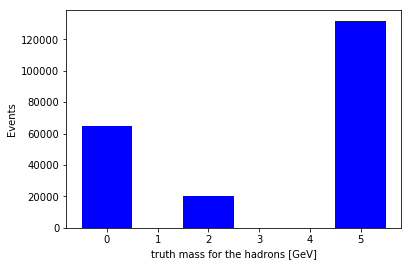

In [11]:
plt.hist(y,bins=np.arange(-0.5,6.5,1.0),color='b')
plt.xlabel('truth mass for the hadrons [GeV]')
plt.ylabel('Events')
plt.show()
plt.savefig('images/jet_dist.png')

So, we can see that this sample contains mostly b and light jets, but we don't want the network to learn that charm jets are unlikely, so when fitting the network, weight the events by

0.33 * (# of evts) / (# of evts where y = i)

to scale the loss function for each of the classes so that the neural net doesn't learn that it's less likely to have charms.

When I first implemented the network, I forgot this step, and I ended up with the network not being able to learn the c mass so that the b-c discrimination curve was poorer than that from the mass correction formulas.


In [12]:
flavorWts = { 0 : 0.33 * (jf_df['jet_LabDr_HadF'] != 15).sum() / (jf_df['jet_LabDr_HadF'] == 0).sum(),
              4 : 0.33 * (jf_df['jet_LabDr_HadF'] != 15).sum() / (jf_df['jet_LabDr_HadF'] == 4).sum(),
              5 : 0.33 * (jf_df['jet_LabDr_HadF'] != 15).sum() / (jf_df['jet_LabDr_HadF'] == 5).sum()
            }

weights = np.array([flavorWts[pdg] for pdg in jf_df['jet_LabDr_HadF'] if pdg != 15])

weights_bs = np.array([1 if pdg==5 else 0 for pdg in jf_df['jet_LabDr_HadF'] if pdg != 15])


allBsCs = (jf_df['jet_LabDr_HadF'] == 4) | (jf_df['jet_LabDr_HadF'] == 5)
heavyFlavorWts = { 0 : 0,
                   4 : 0.33 * allBsCs.sum() / (jf_df['jet_LabDr_HadF'] == 4).sum(),
                   5 : 0.33 * allBsCs.sum() / (jf_df['jet_LabDr_HadF'] == 5).sum()
                 }

weights_bcs = np.array([heavyFlavorWts[pdg] for pdg in jf_df['jet_LabDr_HadF'] if pdg != 15])

In [18]:
1.0 * (jf_df['jet_LabDr_HadF'] == 4).sum() / ( (jf_df['jet_LabDr_HadF'] == 0) | (jf_df['jet_LabDr_HadF'] == 4) ).sum()

0.2348213443952107

### Training and validation sets

Andrew Ng said that for larger datasets, you can use 90% of the data as training, so I began by splitting my data in the ratio

training : CV : test = 90 : 5 : 5

But this gave a relatively noisy loss for the on the validation set, so Michael suggested splitting my data as

training : CV = 70 : 30,

where I've decided to eliminate the test set since it seems straight forward to get more events to look at if I'd like an unbiased sample to evaluate my final network's performance on later.

In [13]:
# Split the data into train and  CV+test sets
idx_file = './models/ixtrainCVtest.pkl'

if os.path.exists(idx_file):

    print "Loading from a previously split train / CV set."
    ix_train, ix_CV = pickle.load(open(idx_file,'rb'))
    
    X_train, y_train, w_train = X.iloc[ix_train].values, y[ix_train], weights[ix_train]
    X_CV, y_CV, w_CV = X.iloc[ix_CV].values, y[ix_CV], weights[ix_CV]
    
else:
    
    ix = np.arange(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
    X_train, X_CV, y_train, y_CV, w_train, w_CV, ix_train, ix_CV = train_test_split(X.values, y, weights, ix, train_size=0.7)

    pickle.dump((ix_train,ix_CV),open(idx_file,'wb'))
    

Loading from a previously split train / CV set.


### Scale the data to zero norm and unit variance

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_CV = scaler.transform(X_CV)

print "train mean = {0:1.4f}, stdev = {1:1.4f}".format(np.mean(X_train),np.var (X_train))
print "val   mean = {0:1.4f}, stdev = {1:1.4f}".format(np.mean(X_CV),np.std(X_CV))

train mean = 0.0000, stdev = 1.0000
val   mean = -0.0018, stdev = 0.8216


# 1. MLP

I can feed in the $m$ and $p_\perp$s for the sum of the tracks, and then the $p_\perp$s of the individual tracks.

Stuff I can play with / tune in this model:

- The number of hidden units to get an understanding for the complexity of the model

- Different cost functions, i.e, the mean squared loss or the mean absolute percent loss.

    The mean squared loss did quite a bit better, although Michael mentioned that we might consider looking into using Mixture Density Networks as well.


- Try different activations, i.e, RELU vs. tanh

- The impact of dropout

    When I don't use dropout, I got similar discrimination power (i.e, identical ROC curves), but my error decreased.
    Also, in general you don't normally apply dropout after a final fully connected layer, because you want the network to be able to use all of this higher level information.


- Try adding an extra layer, just for kicks ;)

    Unfortunately, this didn't increase my discrimination power at all.

- Impact of mitigating the p_perp estimations by their errors


------------------------------------------------------------------------------------

Before, the literature cut the correction if it tried to apply a correction that was too large, it might also be interesting to see how this kind of a "cut" impacts our net, or if the MLP will learn such a correction on its own (what I would expect).

I should also plot the corrected versus the raw mass, and then draw the cut lines suggested from the literature and see how the networks predictions compare.


In [13]:
# This function accepts the bin edges (length N+1)
# and outputs the width of the bins as an
width = lambda edges: edges[1:] - edges[:-1]

# This function accepts two arrays for the height and width of the bin, and
# outputs a vector for the cdf of this histogram
inv_CDF = lambda n,w: 1-np.array([sum(n[0:i+1]*w[0:i+1]) for i in np.arange(0,n.size)])

In [48]:
'''
This function trains an MLP NN using tanh activations in the hidden layers
and a linear activation for the final layer.
It is trained with the adam optimizer, and dropout is added to each layer.


Inputs:

Outputs:

'''

# I'm going to define the parameters 
pdg_ids = [0,4,5]
labels = ['l','c','b']

Nbins = 100
range = (0,10)
    
def MLP(y_train, y_CV, w_train, w_CV, nHidden=10, nLayers=1, nEpochs=100, batchSize=256, 
        objFct='mean_squared_error',activation='tanh',loadModel=False,dropout=False,tag='m'):
    
    filename = 'MLP-{0}neurons{1}{2}{3}-{4}-progress'.format(nHidden,\
                                                          '-mape' if objFct == 'mean_absolute_percentage_error' else '',\
                                                          '-dpt' if dropout else '',
                                                          '-{}'.format(activation) if activation!='tanh' else '',tag)
    loadModel = loadModel & os.path.exists('models/{}.h5'.format(filename)) & os.path.exists('losses/{}.pkl'.format(filename))

    if loadModel:
                
        model = load_model('models/{}.h5'.format(filename))
    
        # Import the previously trained losses
        train_loss_prev, CV_loss_prev = pickle.load(open('losses/{}.pkl'.format(filename),'rb'))
        
    else:

        model = Sequential()

        # Add the hidden layers
        for i in np.arange(nLayers):
            model.add(Dense(nHidden, input_dim=X_train.shape[1], activation=activation))
            if dropout:
                model.add(Dropout(0.5))

        model.add(Dense(1, activation='linear'))

        # Could change this to mean_absolute_percentage_error
        model.compile('adam', objFct) 

    # The inputs need to be passed as np ndarrays
    history = model.fit(X_train , y_train, epochs=nEpochs, batch_size=batchSize, 
              sample_weight=w_train,
              callbacks = [
                  EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                  ModelCheckpoint('models/{}.h5'.format(filename), monitor='val_loss', 
                              verbose=True, save_best_only=True) ],
              validation_data=(X_CV, y_CV, w_CV), 
             )

    # For the predictions, use the best model!
    model = load_model('models/{}.h5'.format(filename))
    
    # Find the predictions for this model on the validation set
    y_CV_pred = model.predict(X_CV, batch_size=batchSize)

    # Also find the predictions on the training set
    y_train_pred = model.predict(X_train, batch_size=batchSize)
            
    # print out some summary information from your NN
    model.summary()
    
    # include the loss from the previous trainings in the history object
    if loadModel:
        history.history['loss']     = train_loss_prev + history.history['loss']
        history.history['val_loss'] = CV_loss_prev    + history.history['val_loss']
    
    # Additionally, save the training and validation loss in case you want to come back and train again
    pickle.dump( (history.history['loss'],history.history['val_loss']) ,  open('losses/{}.pkl'.format(filename),'wb'))
    
    return y_CV_pred, y_train_pred, history, filename
    

In [66]:
def makeTrainingPlots(y_CV_pred, y_train_pred, history,xlabel='$M$ [GeV]',tag='rnn',filepath=''):

    plt.close('all')
    
    # Check if the file path exists, if not create the dir
    if not os.path.exists('images/'+filepath):
        os.makedirs('images/'+filepath)
    
    # Plot the masses for each of the pdg ids
    for pdg_id,label,color in zip(pdg_ids,labels,['b','r','g']):

        n,edges,_ = plt.hist(y_CV_pred[y[ix_CV]==pdg_mass[pdg_id]],label="{}-jets".format(label), 
                             histtype='step',bins=Nbins,range=range,normed=True,color=color)

        w = width(edges)
        
        if pdg_id == 0:
            l_fpr = inv_CDF(n,w)
        elif pdg_id == 4:
            c_fpr = inv_CDF(n,w)
        elif pdg_id == 5:
            tpr   = inv_CDF(n,w)

#         plt.hist(y_train_pred[y[ix_train]==pdg_mass[pdg_id]],label="{} training".format(label), 
#                  histtype='step',bins=Nbins,range=range,normed=True)

    plt.xlabel(xlabel)
    plt.ylabel('Arbitrary Units')
    plt.legend()
    #plt.title(tag)
    plt.savefig('images/{}/train+CV_mass.jpg'.format(filepath))
       
    
    # Only make these diagnostic plots if your input is the target mass
    if xlabel == '$M$ [GeV]':
        
        # Plot the error, predicted mass - the true mass
        plt.figure()
        for pdg_id,label in zip(pdg_ids,labels):
            plt.hist(y_CV_pred[y[ix_CV]==pdg_mass[pdg_id]] - y[ix_CV][y[ix_CV]==pdg_mass[pdg_id]].reshape(-1,1),
                     label="{} CV".format(label),histtype='step',bins=Nbins,range=(-5,5),normed=True)
            plt.hist(y_train_pred[y[ix_train]==pdg_mass[pdg_id]] - y[ix_train][y[ix_train]==pdg_mass[pdg_id]].reshape(-1,1),
                     label="{} CV".format(label),histtype='step',bins=Nbins,range=(-5,5),normed=True)
        plt.xlabel('M(predicted) - M(true)')
        plt.ylabel('Arbitrary Units')
        plt.legend()
        plt.title(tag)
        plt.savefig('images/{}/train+CV_massError.jpg'.format(filepath))    
        
        # Plot the error, predicted p_perp - the true p_perp
        # Get the predicted p_perps
        ptPred_CV    = np.array([0 if m < mch else 0.5*(m**2 - mch**2)/m for m,mch in zip(y_CV_pred,   X['jet_jf_mUncorr'][ix_CV])])
        ptPred_train = np.array([0 if m < mch else 0.5*(m**2 - mch**2)/m for m,mch in zip(y_train_pred,X['jet_jf_mUncorr'][ix_train])])

        plt.figure()
        for pdg_id,label in zip(pdg_ids,labels):
           
            plt.hist(ptPred_CV[y[ix_CV]==pdg_mass[pdg_id]] - y_pt[ix_CV][y[ix_CV]==pdg_mass[pdg_id]],
                     label="{} CV".format(label),histtype='step',bins=Nbins,range=(-5,5),normed=True)
            
            plt.hist(ptPred_train[y[ix_train]==pdg_mass[pdg_id]] - y_pt[ix_train][y[ix_train]==pdg_mass[pdg_id]],
                     label="{} CV".format(label),histtype='step',bins=Nbins,range=(-5,5),normed=True)
        plt.xlabel('$p_\perp$(predicted) - $p_\perp$(true)')
        plt.ylabel('Arbitrary Units')
        plt.legend()
        plt.title(tag)
        plt.savefig('images/{}/train+CV_pPerpError.jpg'.format(filepath))        
        
        plt.figure()
        plt.hist2d( nTrksInJet[ix_CV], y_CV_pred.reshape(-1,),
                   bins=(11,Nbins),range=((-.5,10.5),(0,6)),norm=LogNorm())
        plt.colorbar()
        plt.xlabel('Number of tracks')
        plt.ylabel('M(predicted)')
        #plt.title('{} jets in CV'.format(label))
        plt.savefig('images/{}/CV_mass_vs_nTrks.jpg'.format(filepath)) 
        
        # Plot 2d histograms of the predicted mass vs. the number of tracks
        for pdg_id,label in zip(pdg_ids,labels):
            plt.figure()
            plt.hist2d( nTrksInJet[ix_CV][y[ix_CV]==pdg_mass[pdg_id]], y_CV_pred[y[ix_CV]==pdg_mass[pdg_id]].reshape(-1,),
                       bins=(11,Nbins),range=((-.5,10.5),range),norm=LogNorm())
            plt.colorbar()
            plt.xlabel('Number of tracks')
            plt.ylabel('M(predicted)')
            plt.title('{} jets in CV'.format(label))
            plt.savefig('images/{0}/CV_{1}_mass_vs_nTrks.jpg'.format(filepath,label)) 
        
    # summarize history for the loss function
    if history != 0:
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.ylabel(u'$J(\theta)$')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.savefig('images/{}/loss.jpg'.format(filepath))
          
    plt.show()
    
    # Return the true and false positive rates for the ROC curves
    return l_fpr,c_fpr,tpr

In [54]:
y_CV_pred_mlp_2, y_train_pred_mlp_2, history_mlp_2, filepath = \
    MLP(y_train,y_CV,w_train,w_CV,nHidden=2,nLayers=1,nEpochs=100,
        objFct='mean_squared_error',loadModel=True)

Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 1s - loss: 2.3827 - val_loss: 2.3815
Epoch 2/100
151666/151666 [==============================] - 0s - loss: 2.3827 - val_loss: 2.3815
Epoch 3/100
151666/151666 [==============================] - 0s - loss: 2.3829 - val_loss: 2.3813
Epoch 4/100
151666/151666 [==============================] - 0s - loss: 2.3826 - val_loss: 2.3814
Epoch 5/100
151666/151666 [==============================] - 0s - loss: 2.3825 - val_loss: 2.3813
Epoch 6/100
151666/151666 [==============================] - 0s - loss: 2.3824 - val_loss: 2.3814
Epoch 7/100
151666/151666 [==============================] - 0s - loss: 2.3825 - val_loss: 2.3810
Epoch 8/100
151666/151666 [==============================] - 0s - loss: 2.3823 - val_loss: 2.3817
Epoch 9/100
151666/151666 [==============================] - 0s - loss: 2.3822 - val_loss: 2.3809
Epoch 10/100
151666/151666 [==============================] - 0s - 

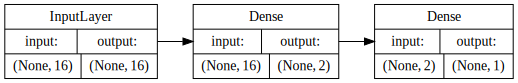

In [73]:
# Look at a graphical summary of the model
model = load_model('models/{}.h5'.format(filepath))
SVG(model_to_dot(model, True, False, 'LR').create(prog='dot', format='svg'))

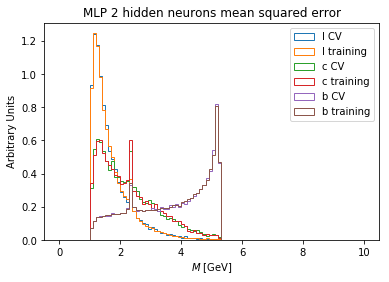

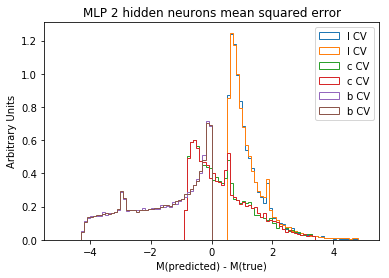

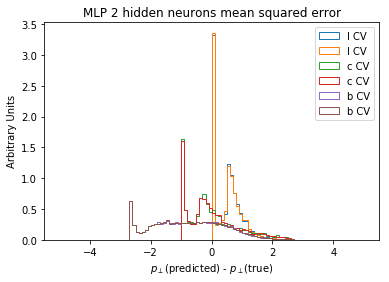

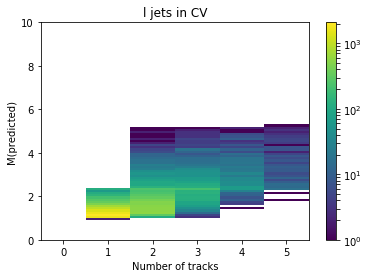

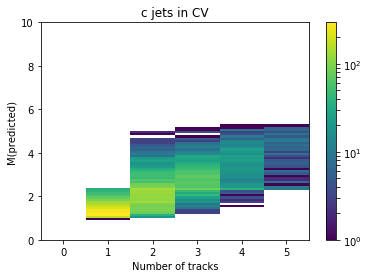

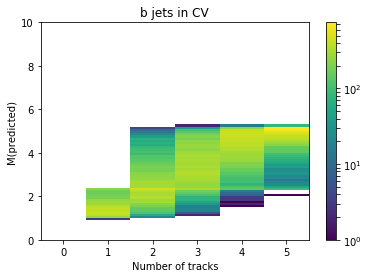

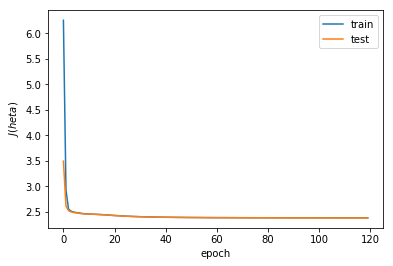

In [65]:
l_fpr_1lay_2units_mse,c_fpr_1lay_2units_mse,tpr_1lay_2units_mse = \
    makeTrainingPlots(y_CV_pred_mlp_2, y_train_pred_mlp_2, 
                      history_mlp_2,tag='MLP 2 hidden neurons mean squared error')

In [62]:
y_CV_pred_mlp_10, y_train_pred_mlp_10, history_mlp_10, filepath = \
    MLP(y_train,y_CV,w_train,w_CV,nHidden=10,nLayers=1,nEpochs=50,objFct='mean_squared_error',
        loadModel=True) 

Train on 151666 samples, validate on 65000 samples
Epoch 1/50
151666/151666 [==============================] - 2s - loss: 2.3646 - val_loss: 2.3390
Epoch 2/50
151666/151666 [==============================] - 1s - loss: 2.3647 - val_loss: 2.3390
Epoch 3/50
151666/151666 [==============================] - 1s - loss: 2.3644 - val_loss: 2.3401
Epoch 4/50
151666/151666 [==============================] - 1s - loss: 2.3646 - val_loss: 2.3386
Epoch 5/50
151666/151666 [==============================] - 1s - loss: 2.3639 - val_loss: 2.3384
Epoch 6/50
151666/151666 [==============================] - 1s - loss: 2.3637 - val_loss: 2.3384
Epoch 7/50
151666/151666 [==============================] - 1s - loss: 2.3637 - val_loss: 2.3377
Epoch 8/50
151666/151666 [==============================] - 1s - loss: 2.3636 - val_loss: 2.3391
Epoch 9/50
151666/151666 [==============================] - 1s - loss: 2.3633 - val_loss: 2.3381
Epoch 10/50
151666/151666 [==============================] - 1s - loss: 2.36

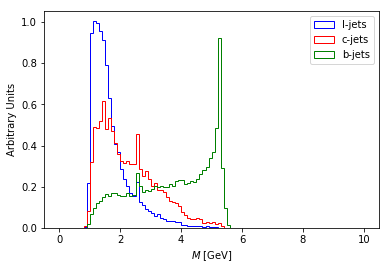

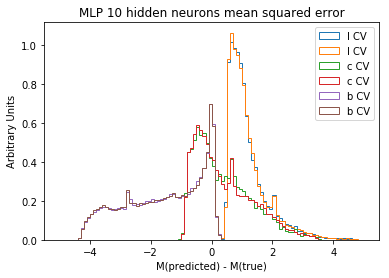

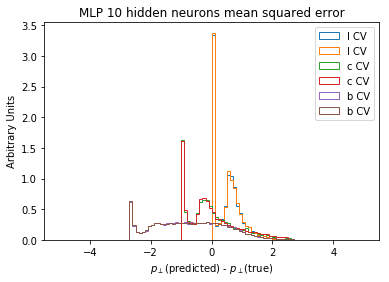

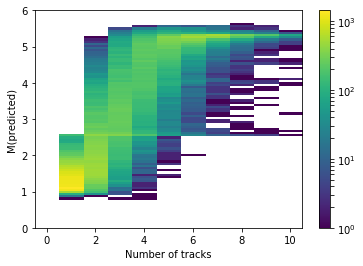

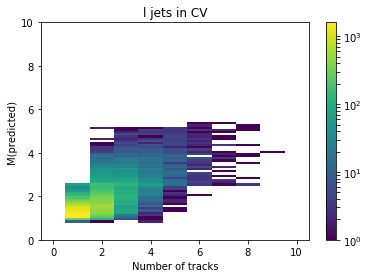

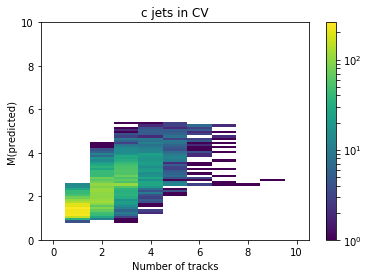

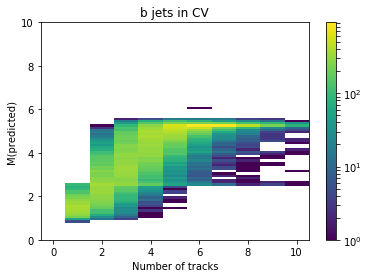

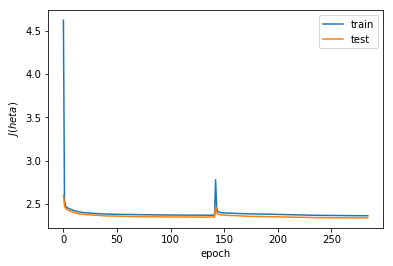

In [67]:
l_fpr_1lay_10units_mse,c_fpr_1lay_10units_mse,tpr_1lay_10units_mse = \
    makeTrainingPlots(y_CV_pred_mlp_10, y_train_pred_mlp_10, 
                      history_mlp_10,tag='MLP 10 hidden neurons mean squared error',filepath=filepath) 

Thoughts:
- When I increase the batch size, the model trains for more epochs. 
- My training loss is much smaller than  my validation loss, which I think could possibly suggest that I'm overfitting?
- Or perhaps I should try decreasing my learning rate?
- I could try going up to 100 hidden neurons, or two hidden layers of 10 neurons each
- The ordinary network had some tails beyond 5 GeV, but this network is learning that you never can have a meson with a mass larger than 5 GeV (I'm not sure how desirable this is). A possible improvement is I could use the truth mass of the hadrons in training instead of the pdg values.

In [70]:
y_CV_pred_mlp_100, y_train_pred_mlp_100, history_mlp_100, filepath = \
    MLP(y_train,y_CV,w_train,w_CV,nHidden=100,nLayers=1,nEpochs=100,objFct='mean_squared_error',loadModel=False)

Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 3s - loss: 3.2579 - val_loss: 2.5002
Epoch 2/100
151666/151666 [==============================] - 3s - loss: 2.4875 - val_loss: 2.4670
Epoch 3/100
151666/151666 [==============================] - 2s - loss: 2.4683 - val_loss: 2.4585
Epoch 4/100
151666/151666 [==============================] - 2s - loss: 2.4589 - val_loss: 2.4499
Epoch 5/100
151666/151666 [==============================] - 2s - loss: 2.4506 - val_loss: 2.4521
Epoch 6/100
151666/151666 [==============================] - 2s - loss: 2.4446 - val_loss: 2.4446
Epoch 7/100
151666/151666 [==============================] - 2s - loss: 2.4378 - val_loss: 2.4353
Epoch 8/100
151666/151666 [==============================] - 2s - loss: 2.4325 - val_loss: 2.4336
Epoch 9/100
151666/151666 [==============================] - 2s - loss: 2.4260 - val_loss: 2.4236
Epoch 10/100
151666/151666 [==============================] - 2s - 

151666/151666 [==============================] - 1s - loss: 2.3573 - val_loss: 2.3646
Epoch 69/100
151666/151666 [==============================] - 1s - loss: 2.3578 - val_loss: 2.3631
Epoch 70/100
151666/151666 [==============================] - 1s - loss: 2.3570 - val_loss: 2.3644
Epoch 71/100
151666/151666 [==============================] - 1s - loss: 2.3558 - val_loss: 2.3654
Epoch 72/100
151666/151666 [==============================] - 1s - loss: 2.3563 - val_loss: 2.3643
Epoch 73/100
151666/151666 [==============================] - 1s - loss: 2.3557 - val_loss: 2.3642
Epoch 74/100
151666/151666 [==============================] - 1s - loss: 2.3561 - val_loss: 2.3624
Epoch 75/100
151666/151666 [==============================] - 1s - loss: 2.3557 - val_loss: 2.3635
Epoch 76/100
151666/151666 [==============================] - 1s - loss: 2.3552 - val_loss: 2.3626
Epoch 77/100
151666/151666 [==============================] - 1s - loss: 2.3552 - val_loss: 2.3622
Epoch 78/100
151666/151

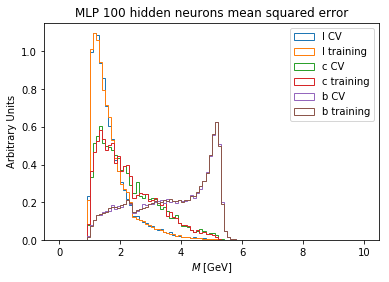

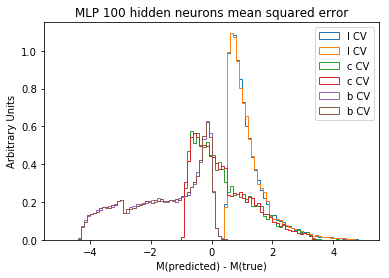

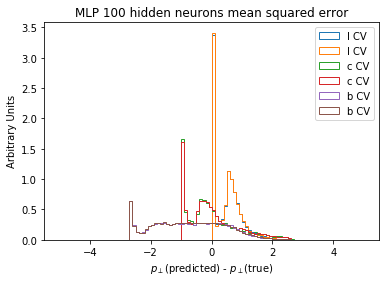

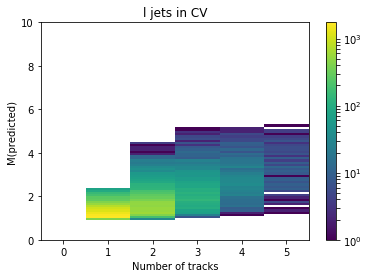

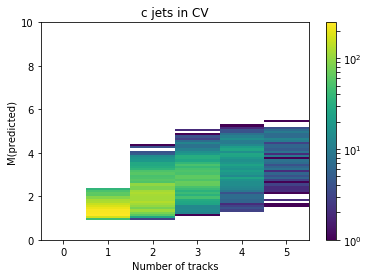

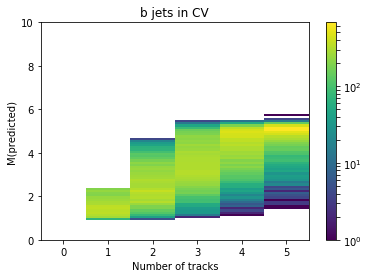

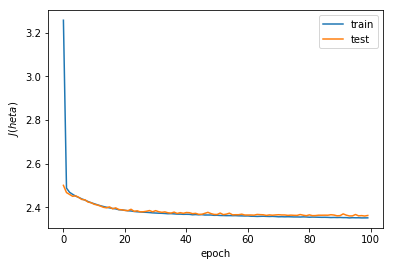

In [71]:
l_fpr_1lay_100units_mse,c_fpr_1lay_100units_mse,tpr_1lay_100units_mse \
    = makeTrainingPlots(y_CV_pred_mlp_100, y_train_pred_mlp_100, history_mlp_100, 
                        tag='MLP 100 hidden neurons mean squared error')

In [81]:
# I'm not going to bother w/ a multi-layered perceptron since my single layered one has better discrimintation
# than JF
# l_fpr_2lay_100units_mse,c_fpr_2lay_100units_mse,tpr_2lay_100units_mse = MLP(nHidden=100,nLayers=2,plotMass=True,objFct='mean_squared_error')

In [64]:
# Get the roc curves for the scalar sum and the vector sum versions of JF.
for pdg_id in pdg_ids:
 
    n_SS,edges_SS,_ = plt.hist(jf_df['jet_jf_m'][jf_df['jet_LabDr_HadF']==pdg_id],
                 label='$m$ directly from the Ntuple', color='r',
                 histtype='step',bins=Nbins,range=range,normed=True)
    n_VS,edges_VS,_ = plt.hist(jf_df['m_MY_TRY'][jf_df['jet_LabDr_HadF']==pdg_id],
                 histtype='step',bins=Nbins,range=range,normed=True)

    # Compute the widths of these bins given the edges
    w = width(edges_SS)
    
    # Then get the true positive rate from sum of the b-curve,
    # and two of the false positve rates from summing up the l and c-curves
    if pdg_id == 0:
        l_fpr_SS = inv_CDF(n_SS,w)
        l_fpr_VS = inv_CDF(n_VS,w)
    elif pdg_id == 4:
        c_fpr_SS = inv_CDF(n_SS,w)
        c_fpr_VS = inv_CDF(n_VS,w)
    elif pdg_id == 5:
        tpr_SS = inv_CDF(n_SS,w)
        tpr_VS = inv_CDF(n_VS,w)
    

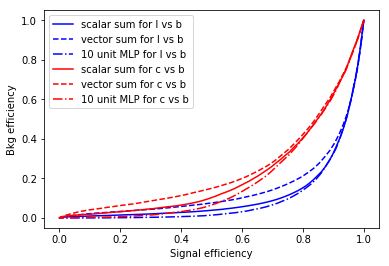

In [65]:
# Draw some ROC curves and compare with the previously used formulas
plt.close('all')

plt.plot(tpr_SS,l_fpr_SS,'b',label='scalar sum for l vs b')
plt.plot(tpr_VS,l_fpr_VS,'b--',label='vector sum for l vs b')
plt.plot(tpr_1lay_10units_mse,l_fpr_1lay_10units_mse,'b-.',label='10 unit MLP for l vs b')

plt.plot(tpr_SS,c_fpr_SS,'r',label='scalar sum for c vs b')
plt.plot(tpr_VS,c_fpr_VS,'r--',label='vector sum for c vs b')
plt.plot(tpr_1lay_10units_mse,c_fpr_1lay_10units_mse,'r-.',label='10 unit MLP for c vs b')

# plt.plot(c_fpr_SS,l_fpr_SS,'g',label='scalar sum for l vs c')
# plt.plot(c_fpr_VS,l_fpr_VS,'g--',label='vector sum for l vs c')
# plt.plot(c_fpr_1lay_10units_mse,l_fpr_1lay_10units_mse,'g-.',label='10 unit MLP for l vs c')

plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()

I feel like it's really the b vs. c discrimination that's suffering the most, and appears to be doing the worst for the higher predicted masses.

Not sure what I need to change: 

(1) Add more model complexity (more layers or more hidden neurons)

(2) Increase the drop out fraction

(3) Is a linear final layer the correct way to phrase this, or should I use some filter steps?

(4) Use a different cost function?

I think using a different cost function should be the way to go, b/c the mean absolute percent error should be the way to go to further penalize incorrectly classified weights when the true weight is larger (i.e, more penalty for incorrectly classifying a charm than a light... or just a thought!)


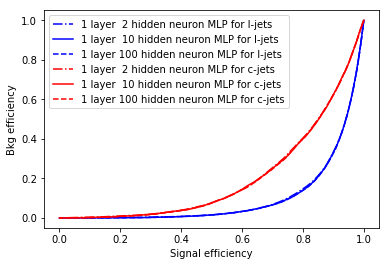

In [82]:
# To see what level of complexity I should be using in my model, compare the roc curve three models I created with 
# the MSE cost function
plt.close('all')

plt.plot(tpr_1lay_2units_mse,  l_fpr_1lay_2units_mse,  'b-.',label='1 layer  2 hidden neuron MLP for l-jets')
plt.plot(tpr_1lay_10units_mse, l_fpr_1lay_10units_mse, 'b-', label='1 layer  10 hidden neuron MLP for l-jets')
plt.plot(tpr_1lay_100units_mse,l_fpr_1lay_100units_mse,'b--',label='1 layer 100 hidden neuron MLP for l-jets')

plt.plot(tpr_1lay_2units_mse,  c_fpr_1lay_2units_mse,'r-.', label='1 layer  2 hidden neuron MLP for c-jets')
plt.plot(tpr_1lay_10units_mse, c_fpr_1lay_10units_mse,'r-',  label='1 layer  10 hidden neuron MLP for c-jets')
plt.plot(tpr_1lay_100units_mse,c_fpr_1lay_100units_mse,'r--',label='1 layer 100 hidden neuron MLP for c-jets')

plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()


It seems like for this simple model, the MLP with 2 hidden neurons has sufficient complexity. I'm not sure why though, b/c the curves get much more spread out as you add more hidden neurons.


Train on 151666 samples, validate on 65000 samples
Epoch 1/50
151666/151666 [==============================] - 2s - loss: 50.1412 - val_loss: 49.8188
Epoch 2/50
151666/151666 [==============================] - 1s - loss: 50.1665 - val_loss: 49.7101
Epoch 3/50
151666/151666 [==============================] - 1s - loss: 50.0373 - val_loss: 49.6071
Epoch 4/50
151666/151666 [==============================] - 1s - loss: 50.1291 - val_loss: 49.7374
Epoch 5/50
151666/151666 [==============================] - 1s - loss: 50.0763 - val_loss: 49.7454
Epoch 6/50
151666/151666 [==============================] - 1s - loss: 50.0554 - val_loss: 49.8301
Epoch 7/50
151666/151666 [==============================] - 1s - loss: 49.9815 - val_loss: 49.7540
Epoch 8/50
151666/151666 [==============================] - 1s - loss: 49.9931 - val_loss: 49.9344
Epoch 9/50
151666/151666 [==============================] - 1s - loss: 50.1365 - val_loss: 49.6411
Epoch 10/50
151666/151666 [==============================]

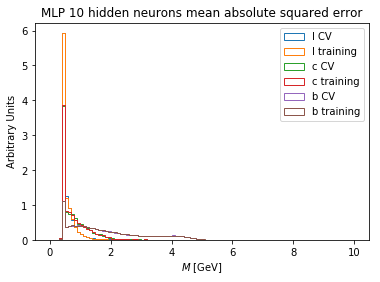

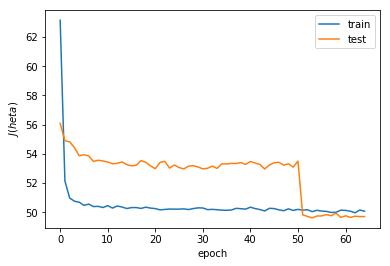

In [96]:
# Modifying the cost function
y_CV_pred_mape_10, y_train_pred_mape_10, history_mape_10, filepath = \
    MLP(y_train,y_CV,w_train,w_CV,nHidden=10,nLayers=1,nEpochs=50,objFct='mean_absolute_percentage_error',loadModel=True,dropout=False)
    
l_fpr_1lay_10units_mape,c_fpr_1lay_10units_mape,tpr_1lay_10units_mape = \
    makeTrainingPlots(y_CV_pred_mape_10, y_train_pred_mape_10, history_mape_10,
                      tag='MLP 10 hidden neurons mean absolute squared error')

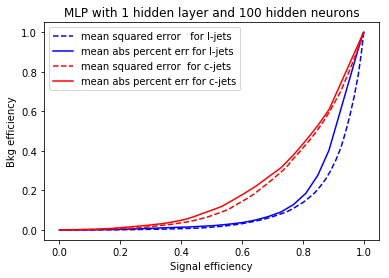

In [100]:
# Compare the discrimination for the two loss functions:

plt.plot(tpr_1lay_10units_mse, l_fpr_1lay_10units_mse, 'b--',label='mean squared error   for l-jets')
plt.plot(tpr_1lay_10units_mape,l_fpr_1lay_10units_mape,'b-',label='mean abs percent err for l-jets')

plt.plot(tpr_1lay_10units_mse, c_fpr_1lay_10units_mse, 'r--',label='mean squared error  for c-jets')
plt.plot(tpr_1lay_10units_mape,c_fpr_1lay_10units_mape,'r-',label='mean abs percent err for c-jets')

plt.title('MLP with 1 hidden layer and 10 hidden neurons')
plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()


### Conclusion:

The mean squared error is dominating over the mean absolute percent error.

Even though my training error is lower than my validation error, I don't think I'm over fitting b/c the curves for the predicted masses for the various jet types look similar for the training and validation sets.



### Investigating the effect of RELU activations

- Run the 10 layer MLP w/ RELU activations
- Evaluate the performance by overlaying the ROC curves.

Train on 151666 samples, validate on 65000 samples
Epoch 1/50
151666/151666 [==============================] - 2s - loss: 6.8184 - val_loss: 9.6355
Epoch 2/50
151666/151666 [==============================] - 1s - loss: 3.3521 - val_loss: 3.6301
Epoch 3/50
151666/151666 [==============================] - 1s - loss: 2.8903 - val_loss: 4.2040
Epoch 4/50
151666/151666 [==============================] - 1s - loss: 2.6876 - val_loss: 3.5773
Epoch 5/50
151666/151666 [==============================] - 1s - loss: 2.5929 - val_loss: 4.3614
Epoch 6/50
151666/151666 [==============================] - 1s - loss: 2.5235 - val_loss: 2.9627
Epoch 7/50
151666/151666 [==============================] - 1s - loss: 2.4833 - val_loss: 2.5240
Epoch 8/50
151666/151666 [==============================] - 1s - loss: 2.4650 - val_loss: 2.5198
Epoch 9/50
151666/151666 [==============================] - 1s - loss: 2.4600 - val_loss: 3.2871
Epoch 10/50
151666/151666 [==============================] - 1s - loss: 2.46

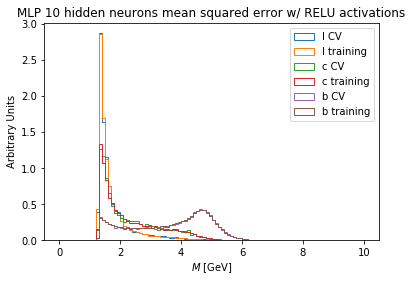

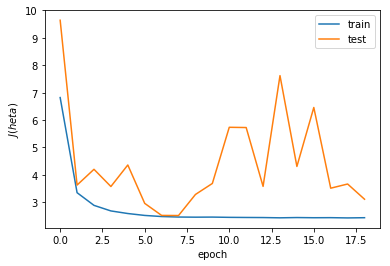

In [84]:
y_CV_pred_mlp_10, y_train_pred_mlp_10, history_mlp_10, filepath = \
    MLP(y_train,y_CV,w_train,w_CV,nHidden=10,nLayers=1,nEpochs=50,objFct='mean_squared_error',
        loadModel=False,activation='relu')
    
l_fpr_1lay_10units_mse_relu,c_fpr_1lay_10units_mse_relu,tpr_1lay_10units_mse_relu = \
    makeTrainingPlots(y_CV_pred_mlp_10, y_train_pred_mlp_10, 
                      history_mlp_10,tag='MLP 10 hidden neurons mean squared error w/ RELU activations') 
      

For the RELU activations, I have comparable discrimination curves, but my validation loss is much higher for some reason.

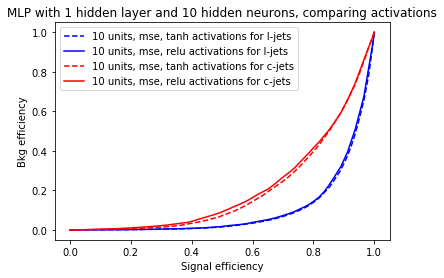

In [85]:
plt.close('all')
plt.plot(tpr_1lay_10units_mse,     l_fpr_1lay_10units_mse,     'b--',label='10 units, mse, tanh activations for l-jets')
plt.plot(tpr_1lay_10units_mse_relu,l_fpr_1lay_10units_mse_relu,'b-',label='10 units, mse, relu activations for l-jets')

plt.plot(tpr_1lay_10units_mse,     c_fpr_1lay_10units_mse,     'r--',label='10 units, mse, tanh activations for c-jets')
plt.plot(tpr_1lay_10units_mse_relu,c_fpr_1lay_10units_mse_relu,'r-',label='10 units, mse, relu activations for c-jets')

plt.title('MLP with 1 hidden layer and 10 hidden neurons, comparing activations')
plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()

### Next steps

- Try learning $p_\perp$ or $m_{ch}$ / $m$ for the jets.
- Add the IP information, $d_0$ and $z_0$ into the network

------------------------------------------------------------------------------------------------------
Longer term:
- Read up on the Mixture Density Network (there's a chapter in Bishop's ML book)
- For stopping the training, and then starting again, use SGD, w/ a momentum term and learning rate scheduler.
- Could also try passing in all the information inside the 4-vectors to learn the correction.

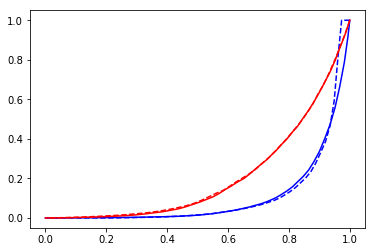

In [145]:
plt.plot(tpr_1lay_10units_mse_normalizedInputs,l_fpr_1lay_10units_mse_normalizedInputs,color='b')
plt.plot(tpr_1lay_10units_mse_dpt,l_fpr_1lay_10units_mse_dpt,'b--')

plt.plot(tpr_1lay_10units_mse_normalizedInputs,c_fpr_1lay_10units_mse_normalizedInputs,color='r')
plt.plot(tpr_1lay_10units_mse_dpt,c_fpr_1lay_10units_mse_dpt,'r--')
plt.show()

### Thoughts:

1. Without dropout, my network trains faster
2. Visually, it's also looking like I'm getting better separation b/w l, c, and b.
3. One thing that concerns me a little bit is that  the higher amount of data in the CV set didn't decrease the noise at all ;(
4. See if the ROC curves are different at all

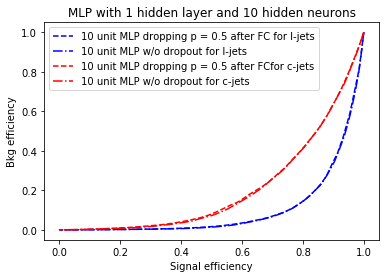

In [25]:
plt.close('all')

plt.plot(tpr_1lay_10units_mse_dpt, l_fpr_1lay_10units_mse_dpt, 'b--',label='10 unit MLP dropping p = 0.5 after FC for l-jets')
plt.plot(tpr_1lay_10units_mse,l_fpr_1lay_10units_mse,'b-.',label='10 unit MLP w/o dropout for l-jets')
plt.plot(tpr_1lay_10units_mse_normalizedInputs,l_fpr_1lay_10units_mse_normalizedInputs,'b-.',label='10 unit MLP w/o dropout normed inputs for l-jets')


plt.plot(tpr_1lay_10units_mse_dpt, c_fpr_1lay_10units_mse_dpt, 'r--',label='10 unit MLP dropping p = 0.5 after FCfor c-jets')
plt.plot(tpr_1lay_10units_mse,c_fpr_1lay_10units_mse,'r-.',label='10 unit MLP w/o dropout for c-jets')
plt.plot(tpr_1lay_10units_mse_normalizedInputs,c_fpr_1lay_10units_mse,'r-.',label='10 unit MLP w/o dropout for c-jets')


plt.title('MLP with 1 hidden layer and 10 hidden neurons')
plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()

### Next plan: Change the mass that you're regressing!

I.e, try learning the correction, or the ratio, $m_{ch}$/m or the $p_\perp$, as calculated from the formula

For light jets, set the $p_\perp$ to 0, so that means for the light jets, we want $m = m_{ch}$.
This is because we don't expect a SV from these elements.

### Learn the targets $m_{ch}$ / $m$
I can just divide a couple of different columns from the data

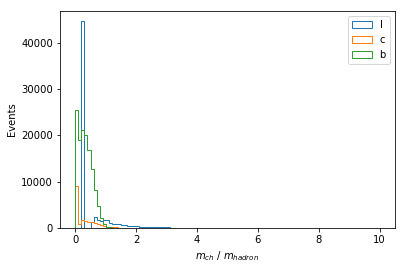

In [16]:
# Take a look at the truth distribution that I'm trying to learn
y_mch_over_m = X['jet_jf_mUncorr'].values / y

Nbins=100
myRange=(0,10)

plt.close('all')
plt.hist(y_mch_over_m[y==pdg_mass[0]],bins=Nbins,range=myRange,histtype='step',label='l')
plt.hist(y_mch_over_m[y==pdg_mass[4]],bins=Nbins,range=myRange,histtype='step',label='c')
plt.hist(y_mch_over_m[y==pdg_mass[5]],bins=Nbins,range=myRange,histtype='step',label='b')
plt.xlabel('$m_{ch}$ / $m_{hadron}$')
plt.ylabel('Events')
plt.legend(loc='best')
plt.show()


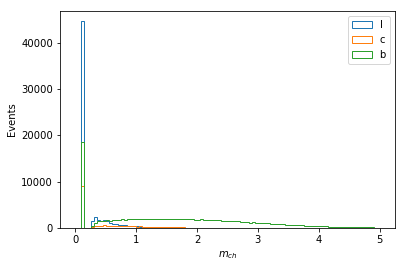

In [27]:
# Investigating where the light jet spike comes from

plt.close('all')
plt.hist(X['jet_jf_mUncorr'].values[y==pdg_mass[0]],bins=Nbins,range=myRange,histtype='step',label='l')
plt.hist(X['jet_jf_mUncorr'].values[y==pdg_mass[4]],bins=Nbins,range=myRange,histtype='step',label='c')
plt.hist(X['jet_jf_mUncorr'].values[y==pdg_mass[5]],bins=Nbins,range=myRange,histtype='step',label='b')
plt.xlabel('$m_{ch}$')
plt.ylabel('Events')
plt.legend(loc='best')
plt.show()

Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 4s - loss: 0.3484 - val_loss: 0.2846
Epoch 2/100
151666/151666 [==============================] - 4s - loss: 0.2844 - val_loss: 0.2737
Epoch 3/100
151666/151666 [==============================] - 4s - loss: 0.2762 - val_loss: 0.2675
Epoch 4/100
151666/151666 [==============================] - 3s - loss: 0.2712 - val_loss: 0.2637
Epoch 5/100
151666/151666 [==============================] - 1s - loss: 0.2682 - val_loss: 0.2618
Epoch 6/100
151666/151666 [==============================] - 2s - loss: 0.2661 - val_loss: 0.2599
Epoch 7/100
151666/151666 [==============================] - 2s - loss: 0.2644 - val_loss: 0.2595
Epoch 8/100
151666/151666 [==============================] - 3s - loss: 0.2634 - val_loss: 0.2580
Epoch 9/100
151666/151666 [==============================] - 4s - loss: 0.2622 - val_loss: 0.2571
Epoch 10/100
151666/151666 [==============================] - 4s - 

151666/151666 [==============================] - 1s - loss: 0.2527 - val_loss: 0.2503
Epoch 32/100
151666/151666 [==============================] - 1s - loss: 0.2526 - val_loss: 0.2504
Epoch 33/100
151666/151666 [==============================] - 1s - loss: 0.2523 - val_loss: 0.2505
Epoch 34/100
151666/151666 [==============================] - 6s - loss: 0.2527 - val_loss: 0.2497
Epoch 35/100
151666/151666 [==============================] - 1s - loss: 0.2521 - val_loss: 0.2499
Epoch 36/100
151666/151666 [==============================] - 0s - loss: 0.2519 - val_loss: 0.2501
Epoch 37/100
151666/151666 [==============================] - 2s - loss: 0.2521 - val_loss: 0.2496
Epoch 38/100
151666/151666 [==============================] - 5s - loss: 0.2519 - val_loss: 0.2492
Epoch 39/100
151666/151666 [==============================] - 0s - loss: 0.2514 - val_loss: 0.2505
Epoch 40/100
151666/151666 [==============================] - 0s - loss: 0.2518 - val_loss: 0.2497
Epoch 41/100
151666/151

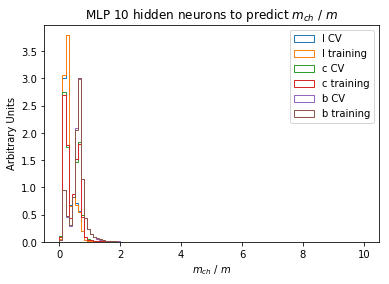

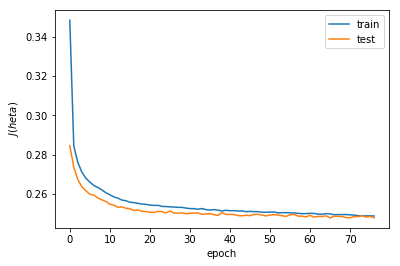

In [49]:
y_train, y_CV = y_mch_over_m[ix_train], y_mch_over_m[ix_CV]

y_CV_pred, y_train_pred, history, filepath = \
    MLP(y_train,y_CV,w_train,w_CV,nHidden=10,nLayers=1,nEpochs=100,
        objFct='mean_squared_error',loadModel=False,tag='mch_over_m')
        
l_fpr_1lay_mch_over_m,c_fpr_1lay_mch_over_m,tpr_1lay_mch_over_m = \
    makeTrainingPlots(y_CV_pred, y_train_pred, history,xlabel='$m_{ch}$ / $m$',
                      tag='MLP 10 hidden neurons to predict $m_{ch}$ / $m$')

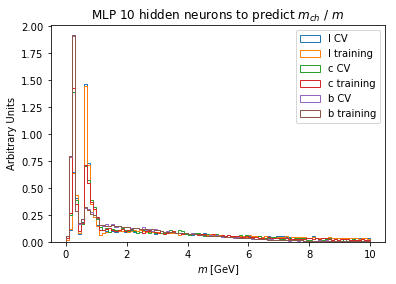

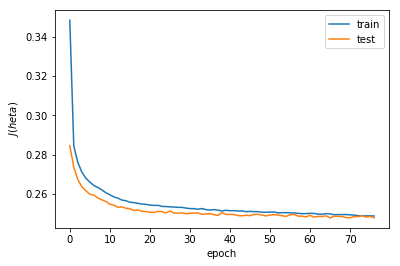

In [50]:
# Next, plot the actual mass curves
y_CV_m_from_res    = np.array([mch/pred for pred,mch in zip(y_CV_pred,   X['jet_jf_mUncorr']) ]) 
y_train_m_from_res = np.array([mch/pred for pred,mch in zip(y_train_pred,X['jet_jf_mUncorr']) ]) 

l_fpr_1lay_mch_over_m,c_fpr_1lay_mch_over_m,tpr_1lay_mch_over_m = \
    makeTrainingPlots(y_CV_m_from_res, y_train_m_from_res, history,xlabel='$m$ [GeV]',
                      tag='MLP 10 hidden neurons to predict $m_{ch}$ / $m$')


But... the problem is that by training like this, you're essentially training a multi-class regression, b/c in data, you don't know what the b,c,l is before applying this regression factor.

1. So... try JUST training on the bs instead, and then see how this regression performs on the lights as well
2. Then you can try training on the cs and the bs
3. You wouldn't expect this regression for getting the cs and the bs to reconstruct an invariant mass for the lights.

This should be pretty straightfoward to implement with the sample_weights option!

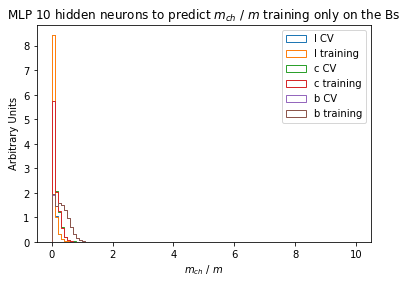

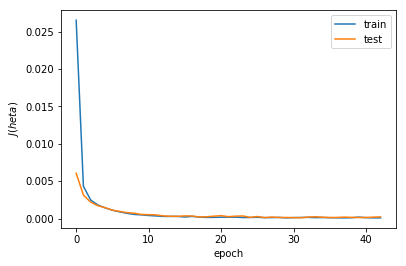

In [44]:
y_train, y_CV = y_mch_over_m[ix_train], y_mch_over_m[ix_CV]
wbs_train, wbs_CV = weights_bs[ix_train], weights_bs[ix_CV]

y_CV_pred, y_train_pred, history, filepath = \
    MLP(y_train, y_CV, wbs_train, wbs_CV, nHidden=10, nLayers=1, nEpochs=100,
        objFct='mean_squared_error', loadModel=False, tag='mch_over_m_trainBsOnly')
        
l_fpr_1lay_mch_over_m_bsOnly,c_fpr_1lay_mch_over_m_bsOnly,tpr_1lay_mch_over_m_bsOnly = \
    makeTrainingPlots(y_CV_pred, y_train_pred, history,xlabel='$m_{ch}$ / $m$',
                      tag='MLP 10 hidden neurons to predict $m_{ch}$ / $m$ training only on the Bs')

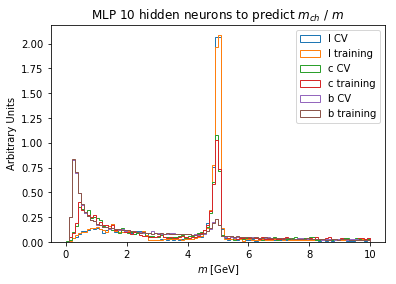

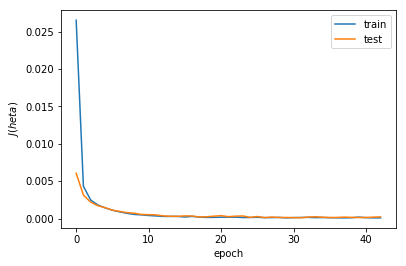

In [45]:
# Next, plot the actual mass curves
y_CV_m_from_res_bsOnly    = np.array([mch/pred for pred,mch in zip(y_CV_pred,   X['jet_jf_mUncorr']) ]) 
y_train_m_from_res_bsOnly = np.array([mch/pred for pred,mch in zip(y_train_pred,X['jet_jf_mUncorr']) ]) 

l_fpr_1lay_mch_over_m_bsOnly,c_fpr_1lay_mch_over_m_bsOnly,tpr_1lay_mch_over_m_bsOnly = \
    makeTrainingPlots(y_CV_m_from_res_bsOnly, y_train_m_from_res_bsOnly, history,xlabel='$m$ [GeV]',
                      tag='MLP 10 hidden neurons to predict $m_{ch}$ / $m$')

Unfortunately, just training on the bs produces an artificial peak for the lights and charms @ the b-mass.

Try training on the Bs and the Cs, and then compare the ROC curves.

Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 2s - loss: 0.0478 - val_loss: 0.0339
Epoch 2/100
151666/151666 [==============================] - 2s - loss: 0.0321 - val_loss: 0.0299
Epoch 3/100
151666/151666 [==============================] - 1s - loss: 0.0296 - val_loss: 0.0285
Epoch 4/100
151666/151666 [==============================] - 1s - loss: 0.0285 - val_loss: 0.0274
Epoch 5/100
151666/151666 [==============================] - 2s - loss: 0.0279 - val_loss: 0.0267
Epoch 6/100
151666/151666 [==============================] - 2s - loss: 0.0272 - val_loss: 0.0262
Epoch 7/100
151666/151666 [==============================] - 2s - loss: 0.0267 - val_loss: 0.0256
Epoch 8/100
151666/151666 [==============================] - 1s - loss: 0.0264 - val_loss: 0.0250
Epoch 9/100
151666/151666 [==============================] - 3s - loss: 0.0257 - val_loss: 0.0247
Epoch 10/100
151666/151666 [==============================] - 1s - 

151666/151666 [==============================] - 2s - loss: 0.0235 - val_loss: 0.0234
Epoch 33/100
151666/151666 [==============================] - 1s - loss: 0.0234 - val_loss: 0.0236
Epoch 34/100
151666/151666 [==============================] - 1s - loss: 0.0236 - val_loss: 0.0235
Epoch 35/100
151666/151666 [==============================] - 1s - loss: 0.0234 - val_loss: 0.0235
Epoch 36/100
151666/151666 [==============================] - 1s - loss: 0.0235 - val_loss: 0.0236
Epoch 37/100
151666/151666 [==============================] - 0s - loss: 0.0235 - val_loss: 0.0236
Epoch 38/100
151666/151666 [==============================] - 0s - loss: 0.0235 - val_loss: 0.0235
Epoch 39/100
151666/151666 [==============================] - 1s - loss: 0.0235 - val_loss: 0.0235
Epoch 40/100
151666/151666 [==============================] - 1s - loss: 0.0234 - val_loss: 0.0239
Epoch 41/100
151666/151666 [==============================] - 0s - loss: 0.0234 - val_loss: 0.0236
Epoch 42/100
151666/151

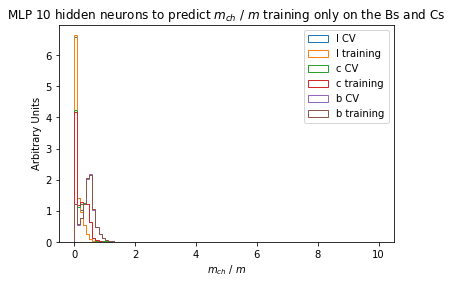

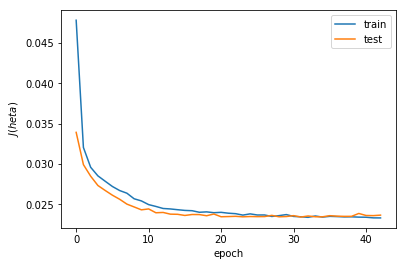

In [47]:
y_train, y_CV = y_mch_over_m[ix_train], y_mch_over_m[ix_CV]
wbcs_train, wbcs_CV = weights_bcs[ix_train], weights_bcs[ix_CV]

y_CV_pred, y_train_pred, history, filepath = \
    MLP(y_train, y_CV, wbcs_train, wbcs_CV, nHidden=10, nLayers=1, nEpochs=100,
        objFct='mean_squared_error', loadModel=False, tag='mch_over_m_trainBandCs')
        
l_fpr_1lay_mch_over_m_bcs,c_fpr_1lay_mch_over_m_bcs,tpr_1lay_mch_over_m_bcs = \
    makeTrainingPlots(y_CV_pred, y_train_pred, history,xlabel='$m_{ch}$ / $m$',
                      tag='MLP 10 hidden neurons to predict $m_{ch}$ / $m$ training only on the Bs and Cs')

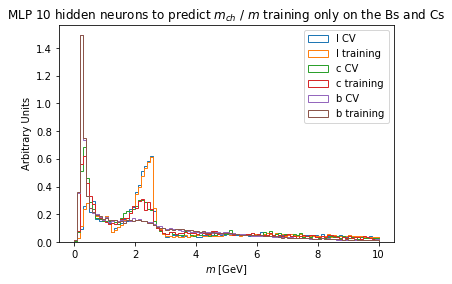

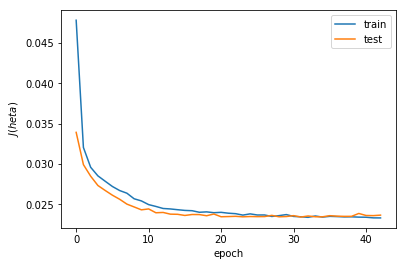

In [48]:
# Next, plot the actual mass curves
y_CV_m_from_res_bcs    = np.array([mch/pred for pred,mch in zip(y_CV_pred,   X['jet_jf_mUncorr']) ]) 
y_train_m_from_res_bcs = np.array([mch/pred for pred,mch in zip(y_train_pred,X['jet_jf_mUncorr']) ]) 

l_fpr_1lay_mch_over_m_bcs,c_fpr_1lay_mch_over_m_bcs,tpr_1lay_mch_over_m_bcs = \
    makeTrainingPlots(y_CV_m_from_res_bcs, y_train_m_from_res_bcs, history,xlabel='$m$ [GeV]',
                      tag='MLP 10 hidden neurons to predict $m_{ch}$ / $m$ training only on the Bs and Cs')

Finally, compare the ROC curves, and as a baseline, use the 10 unit MLP for predicting M.

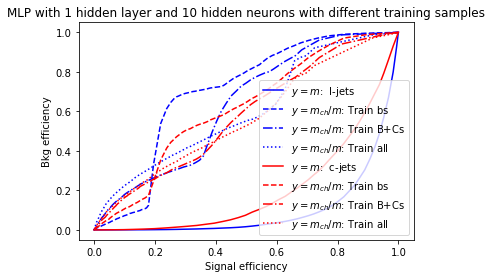

In [67]:
plt.close('all')

plt.plot(tpr_1lay_10units_mse,   l_fpr_1lay_10units_mse,   'b-', label='$y = m$:  l-jets')
plt.plot(tpr_1lay_mch_over_m_bsOnly, l_fpr_1lay_mch_over_m_bsOnly, 'b--',label='$y = m_{ch}/m$: Train bs')
plt.plot(tpr_1lay_mch_over_m_bcs,    l_fpr_1lay_mch_over_m_bcs,    'b-.',label='$y = m_{ch}/m$: Train B+Cs')
plt.plot(tpr_1lay_mch_over_m,        l_fpr_1lay_mch_over_m,        'b:', label='$y = m_{ch}/m$: Train all')

plt.plot(tpr_1lay_10units_mse, c_fpr_1lay_10units_mse, 'r-',label='$y = m$:  c-jets')
plt.plot(tpr_1lay_mch_over_m_bsOnly, c_fpr_1lay_mch_over_m_bsOnly, 'r--',label='$y = m_{ch}/m$: Train bs')
plt.plot(tpr_1lay_mch_over_m_bcs,    c_fpr_1lay_mch_over_m_bcs,    'r-.',label='$y = m_{ch}/m$: Train B+Cs')
plt.plot(tpr_1lay_mch_over_m,        c_fpr_1lay_mch_over_m,        'r:', label='$y = m_{ch}/m$: Train all')

plt.title('MLP with 1 hidden layer and 10 hidden neurons with different training samples')
plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()

Conclusions:
- I don't think $m_{ch}/m$ makes a good target value.
- If I want a high signal efficiency, it's important to train on the whole sample

### Try learning the correction $\Delta m = m - m_{ch}$

- Start of by plotting the truth distribution to this variable.

- Don't apply any correction to the light jets.


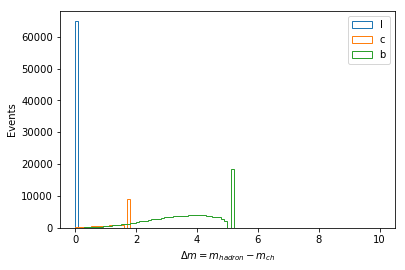

In [15]:
y_dm = np.where( y != pdg_mass[0] , y - X['jet_jf_mUncorr'].values, np.zeros(y.size) )

Nbins=100
myRange=(0,10)

plt.close('all')
plt.hist(y_dm[y==pdg_mass[0]],bins=Nbins,range=myRange,histtype='step',label='l')
plt.hist(y_dm[y==pdg_mass[4]],bins=Nbins,range=myRange,histtype='step',label='c')
plt.hist(y_dm[y==pdg_mass[5]],bins=Nbins,range=myRange,histtype='step',label='b')
plt.xlabel('$\Delta m = m_{hadron} - m_{ch}$')
plt.ylabel('Events')
plt.legend(loc='best')
plt.show()

Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 1s - loss: 3.1764 - val_loss: 2.5731
Epoch 2/100
151666/151666 [==============================] - 1s - loss: 2.5328 - val_loss: 2.4922
Epoch 3/100
151666/151666 [==============================] - 1s - loss: 2.4880 - val_loss: 2.4687
Epoch 4/100
151666/151666 [==============================] - 1s - loss: 2.4727 - val_loss: 2.4600
Epoch 5/100
151666/151666 [==============================] - 1s - loss: 2.4644 - val_loss: 2.4514
Epoch 6/100
151666/151666 [==============================] - 1s - loss: 2.4581 - val_loss: 2.4477
Epoch 7/100
151666/151666 [==============================] - 1s - loss: 2.4536 - val_loss: 2.4423
Epoch 8/100
151666/151666 [==============================] - 1s - loss: 2.4500 - val_loss: 2.4395
Epoch 9/100
151666/151666 [==============================] - 1s - loss: 2.4466 - val_loss: 2.4373
Epoch 10/100
151666/151666 [==============================] - 1s - 

151666/151666 [==============================] - 1s - loss: 2.4194 - val_loss: 2.4114
Epoch 32/100
151666/151666 [==============================] - 1s - loss: 2.4188 - val_loss: 2.4092
Epoch 33/100
151666/151666 [==============================] - 1s - loss: 2.4181 - val_loss: 2.4122
Epoch 34/100
151666/151666 [==============================] - 1s - loss: 2.4179 - val_loss: 2.4076
Epoch 35/100
151666/151666 [==============================] - 1s - loss: 2.4168 - val_loss: 2.4074
Epoch 36/100
151666/151666 [==============================] - 1s - loss: 2.4162 - val_loss: 2.4061
Epoch 37/100
151666/151666 [==============================] - 1s - loss: 2.4157 - val_loss: 2.4062
Epoch 38/100
151666/151666 [==============================] - 1s - loss: 2.4146 - val_loss: 2.4052
Epoch 39/100
151666/151666 [==============================] - 1s - loss: 2.4153 - val_loss: 2.4055
Epoch 40/100
151666/151666 [==============================] - 1s - loss: 2.4147 - val_loss: 2.4040
Epoch 41/100
151666/151

151666/151666 [==============================] - 1s - loss: 2.4063 - val_loss: 2.3961
Epoch 67/100
151666/151666 [==============================] - 1s - loss: 2.4059 - val_loss: 2.3969
Epoch 68/100
151666/151666 [==============================] - 1s - loss: 2.4058 - val_loss: 2.3969
Epoch 69/100
151666/151666 [==============================] - 1s - loss: 2.4066 - val_loss: 2.3955
Epoch 70/100
151666/151666 [==============================] - 1s - loss: 2.4063 - val_loss: 2.3964
Epoch 71/100
151666/151666 [==============================] - 1s - loss: 2.4052 - val_loss: 2.3945
Epoch 72/100
151666/151666 [==============================] - 1s - loss: 2.4049 - val_loss: 2.3960
Epoch 73/100
151666/151666 [==============================] - 0s - loss: 2.4053 - val_loss: 2.3983
Epoch 74/100
151666/151666 [==============================] - 1s - loss: 2.4053 - val_loss: 2.3961
Epoch 75/100
151666/151666 [==============================] - 1s - loss: 2.4052 - val_loss: 2.3941
Epoch 76/100
151666/151

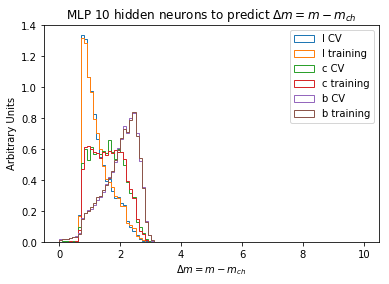

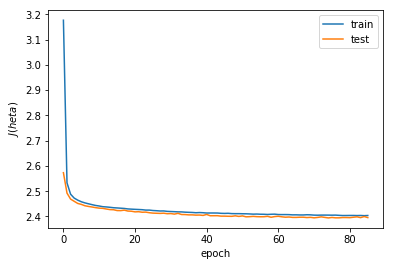

In [67]:
y_train, y_CV = y_dm[ix_train], y_dm[ix_CV]

y_CV_pred, y_train_pred, history, filepath = \
    MLP(y_train,y_CV,w_train,w_CV,nHidden=10,nLayers=1,nEpochs=100,objFct='mean_squared_error',loadModel=e)   
    
l_fpr_1lay_dm,c_fpr_1lay_dm,tpr_1lay_dm = \
    makeTrainingPlots(y_CV_pred, y_train_pred, history,xlabel='$\Delta m = m - m_{ch}$',
                      tag='MLP 10 hidden neurons to predict $\Delta m = m - m_{ch}$')
    
# Take the dm outputs from the NN and get the mass predition
# m_pred = dm + m_ch
y_CV_pred += X_CV[:,0].reshape(y_CV_pred.size,1)
y_train_pred += X_train[:,0].reshape(y_train_pred.size,1)

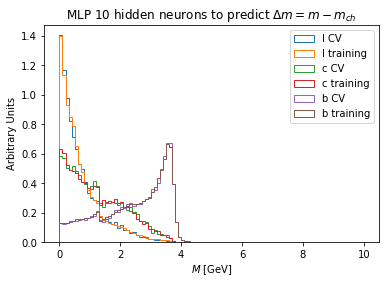

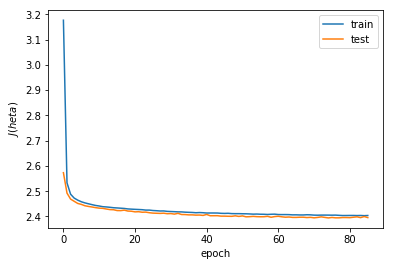

In [68]:
l_fpr_1lay_dm,c_fpr_1lay_dm,tpr_1lay_dm = \
    makeTrainingPlots(y_CV_pred, y_train_pred, history,
                      tag='MLP 10 hidden neurons to predict $\Delta m = m - m_{ch}$')

### Lastly, try to predict the $p_\perp$ values

- Again, set $p_\perp$ = 0 for light jets.
- Solve for $p_\perp$ by solving $m = \sqrt{m_{ch}^2 + p_\perp} + |p_\perp|$:

    $p_\perp = \frac{m^2 - m_{ch}^2}{2m}$

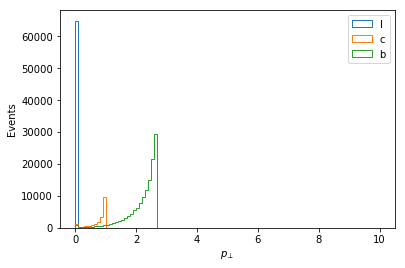

In [115]:
Nbins = 100
myRange = (0,10)

plt.close('all')
plt.hist(y_pt[y==pdg_mass[0]],bins=Nbins,range=myRange,histtype='step',label='l')
plt.hist(y_pt[y==pdg_mass[4]],bins=Nbins,range=myRange,histtype='step',label='c')
plt.hist(y_pt[y==pdg_mass[5]],bins=Nbins,range=myRange,histtype='step',label='b')
plt.xlabel('$p_\perp$')
plt.ylabel('Events')
plt.legend(loc='best')
plt.show()

Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 4s - loss: 0.7312 - val_loss: 0.7371
Epoch 2/100
151666/151666 [==============================] - 3s - loss: 0.7297 - val_loss: 0.7369
Epoch 3/100
151666/151666 [==============================] - 1s - loss: 0.7293 - val_loss: 0.7372
Epoch 4/100
151666/151666 [==============================] - 1s - loss: 0.7290 - val_loss: 0.7371
Epoch 5/100
151666/151666 [==============================] - 1s - loss: 0.7288 - val_loss: 0.7374
Epoch 6/100
151666/151666 [==============================] - 2s - loss: 0.7286 - val_loss: 0.7369
Epoch 7/100
151666/151666 [==============================] - 1s - loss: 0.7283 - val_loss: 0.7363
Epoch 8/100
151666/151666 [==============================] - 1s - loss: 0.7282 - val_loss: 0.7368
Epoch 9/100
151666/151666 [==============================] - 1s - loss: 0.7281 - val_loss: 0.7364
Epoch 10/100
151666/151666 [==============================] - 3s - 

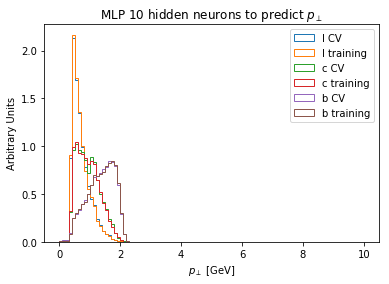

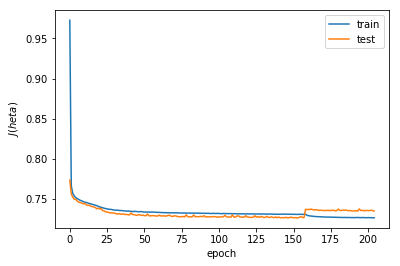

In [90]:
y_CV_pred, y_train_pred, history, filepath = \
    MLP(y_pt[ix_train],y_pt[ix_CV],w_train,w_CV,nHidden=10,nLayers=1,nEpochs=100,
        objFct='mean_squared_error',loadModel=True,tag='pt')
        
l_fpr_1lay_pt,c_fpr_1lay_pt,tpr_1lay_pt = \
    makeTrainingPlots(y_CV_pred, y_train_pred, history,xlabel='$p_\perp$ [GeV]',
                      tag='MLP 10 hidden neurons to predict $p_\perp$')

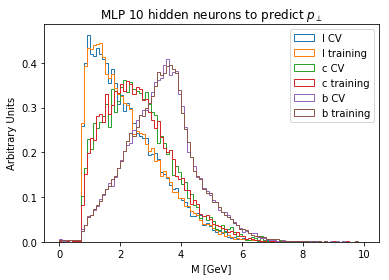

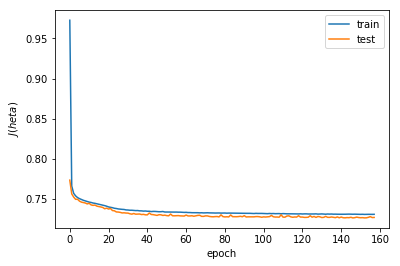

In [59]:
# Plot the mass and get the ROC curves

y_CV_m = np.array([np.sqrt(mch**2 + pt**2) + pt for mch,pt in zip(X['jet_jf_mUncorr'],y_CV_pred)])
y_train_m = np.array([np.sqrt(mch**2 + pt**2) + pt for mch,pt in zip(X['jet_jf_mUncorr'],y_train_pred)])

l_fpr_1lay_m_from_pt,c_fpr_1lay_m_from_pt,tpr_1lay_m_from_pt = \
    makeTrainingPlots(y_CV_m, y_train_m, history,xlabel='M [GeV]',
                      tag='MLP 10 hidden neurons to predict $p_\perp$')


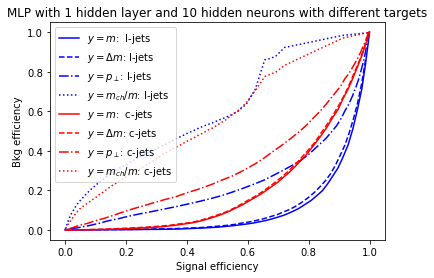

In [82]:
# Overlay the ROC curves to compare the performance of different types of predictions you can make

plt.close('all')

plt.plot(tpr_1lay_10units_mse, l_fpr_1lay_10units_mse, 'b-',label='$y = m$:  l-jets')
plt.plot(tpr_1lay_dm,l_fpr_1lay_dm,'b--',label='$y = \Delta m$: l-jets')
plt.plot(tpr_1lay_m_from_pt,l_fpr_1lay_m_from_pt,'b-.',label='$y = p_\perp$: l-jets')
plt.plot(tpr_1lay_mch_over_m,l_fpr_1lay_mch_over_m,'b:',label='$y = m_{ch}/m$: l-jets')

plt.plot(tpr_1lay_10units_mse, c_fpr_1lay_10units_mse, 'r-',label='$y = m$:  c-jets')
plt.plot(tpr_1lay_dm,c_fpr_1lay_dm,'r--',label='$y = \Delta m$: c-jets')
plt.plot(tpr_1lay_m_from_pt,c_fpr_1lay_m_from_pt,'r-.',label='$y = p_\perp$: c-jets')
plt.plot(tpr_1lay_,c_fpr_1lay_mch_over_m,'r:',label='$y = m_{ch}/m$: c-jets')

plt.title('MLP with 1 hidden layer and 10 hidden neurons with different targets')
plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()


So, it appears that having the target values be $y = m$ gives the best discrimination power, although the targets $y = \Delta m$ gives comparable performance as well.

I think the fractional correction targets $y = m_{ch} / m$ just didn't offer enough discrimination between the 3 classes for the network to learn, and the $p_\perp$ distribution is killed by the tails.

In [98]:
# Compare the performance of these models in terms of their errors
modelErrors = {
    'model_mlp_2'     : np.min(history_mlp_2.history['val_loss']),
    'model_mlp_10'    : np.min(history_mlp_10.history['val_loss']),
    'model_mlp_100'   : np.min(history_mlp_100.history['val_loss']),
    'model_mape_10'   : np.min(history_rnn_20_20.history['val_loss']),
    #'model_rnn_20_20' : np.min(history_rnn_20_20.history['val_loss'])
}

for key, value in modelErrors.iteritems():
    
    print('{0:15s} error: {1:1.3f}'.format(key, value) )
    

model_rnn_20_20 error: 3.434
model_mlp_10    error: 3.302
model_mlp_100   error: 3.220
model_mape_10   error: 3.434
model_mlp_2     error: 3.656


# 2. Basic RNN


### Goals for this study: 
- With the same high level features from the MLP, try to get the an RNN up and running that can do at least as well as the MLP.
- Experiment with the difference b/w the LSTM, GRU, and SimpleRNN functions
- Add an attention mechanism to prevent just random ordering for the tracks
- Perhaps you could also explore feeding in the IP info $d_0$ and $z_0$ in here as well(?)

Michela's notebook demonstrates how to make a NN with GRUs...
It demonstrates how to solve a classification problem for whether an event comes from
$t \bar{t}$, Drell-Yan (not sure what that means), or W+jets.

Since the number of jets, muons, electrons and photons changes from event to event, she uses and RNN for each of these variables, where the RNN consists of a masking, GRU, and dropout layer, and then merges the 4 streams into the previously developed event level network.
- In the createStream function, she scales the inputs to 0 mean and unit variance. 
- She has a function sortObjects that (I presume) sorts each type particles according to one of the particle's attributes (i.e, RNNIP sorts the tracks by $s_{d_0}$ )

--------------------------------------------------------------------------------

Long Short Term Memory (LSTM) cells and Gated Linear Units (GLUs) are ways of mitigating the vanishing gradient problem that plagues deep neural networks (since an RNN can be viewed as an MLP with constrained weights rolled out i for the different time steps).

It seems like recent papers point to GLUs doing better than LSTMs, and they have fewer parameters to train.

<font color='red'>
To do list: read this paper:
https://www.researchgate.net/publication/307889449
</font>


(It might also be good to explain to yourself LSTMs and GRUs here, but I'm not going to do that now.)

The discrepancy b/w the validation and training errors indicate that the model is \emph{overfitting}, which is part of the motivation for moving to an RNN to solve this problem.

Since I learned from my initial studies that the mean squared error performed better than the mean absolute error, I'm not going to vary this in my RNN study.


### Preprocessing

The column in my df 'jet_trk_pPerp' is a list of the $p_\perp$ for all the tracks.

Michela's dfs store the particle info in a similar way, so I shouldn't need to preprocess it too much.

In [16]:
# A final bit of preprocesing for the basic rnn, have the shapes be compatible with the layer expectations!

# The first two columns of X have the m_ch and pPerp values for the trks
jet_values = X_train[:,:2]
jet_CV = X_CV[:,:2]


Plot the discrimination of the RNN vs. the JF mass discrimination

Compare with the 100-layered MLP performance.

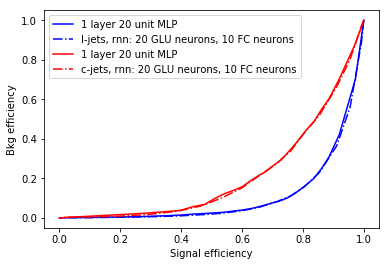

In [97]:
# plt.close('all')

# plt.plot(tpr_1lay_100units_mse ,l_fpr_1lay_100units_mse ,'b',label='1 layer 100 unit MLP')
# plt.plot(tpr_rnn_20_20,l_fpr_rnn_20_20,'b-.',label='l-jets, rnn: 20 GLU neurons, 20 FC neurons')

# plt.plot(tpr_1lay_100units_mse, c_fpr_1lay_100units_mse,'r',label='1 layer 100 unit MLP')
# plt.plot(tpr_rnn_20_20,c_fpr_rnn_20_20,'r-.',label='c-jets, rnn: 20 GLU neurons, 20 FC neurons')

# plt.xlabel('Signal efficiency')
# plt.ylabel('Bkg efficiency')
# plt.legend(loc='best')
# plt.show()

I'm going to first start off by sorting the tracks by $s_{d0}$, just like they did in the RNNIP tagger, and then I'm going to try to implement the attention mechanism to allow the network to \emph{learn} which parts of the sentence are the most important to look at. 

Now, preprocess the data so you have an extra dimension in the track variables, and now pad w/ -999 (b/c why not...)
Michela did this in FFNN_RNN.

The 3 functions below have been shamelessly borrowed from Michela ;)

In [17]:
def create_stream(df, num_obj, sort_col):
   
    n_variables = df.shape[1]
    var_names = df.keys()

    data = np.zeros((df.shape[0], num_obj, n_variables), dtype='float32')

    # -- call functions to build X (a.k.a. data)                                                                                                                                                                      
    sort_objects(df, data, sort_col, num_obj)
    
    # -- ix_{train, test} from above or from previously stored ordering
    Xobj_train = data[ix_train]
    Xobj_CV = data[ix_CV]
    #Xobj_test = data[ix_test]
    
    #print 'Scaling features ...'
    scale(Xobj_train, var_names, savevars=True) # scale training sample and save scaling
    scale(Xobj_CV, var_names, savevars=False) # apply scaling to CV set
    #scale(Xobj_test, var_names, savevars=False) # apply scaling to test set
    return Xobj_train, Xobj_CV#, Xobj_test

In [18]:
def sort_objects(df, data, SORT_COL, max_nobj):
    ''' 
    sort objects using your preferred variable
    
    Args:
    -----
        df: a dataframe with event-level structure where each event is described by a sequence of jets, muons, etc.
        data: an array of shape (nb_events, nb_particles, nb_feat
        ures)
        SORT_COL: a string representing the column to sort the objects by
        max_nobj: number of particles to cut off at. if >, truncate, else, -999 pad
    
    Returns:
    --------
        modifies @a data in place. Pads with -999
    
    '''
    import tqdm # allows you to show the progress bar when iterating over this for loop
    # i = event number, event = all the variables for that event 
    for i, event in tqdm.tqdm(df.iterrows(), total=df.shape[0]): 

        # objs = [[pt's], [eta's], ...] of particles for each event 
        objs = np.array(
                [v for v in event.get_values()], 
                dtype='float32'
            )[:, (np.argsort(event[SORT_COL]))[::-1]]

        # total number of tracks per jet      
        nobjs = objs.shape[1] 

        # take all tracks unless there are more than n_tracks 
        data[i, :(min(nobjs, max_nobj)), :] = objs.T[:(min(nobjs, max_nobj)), :] 

        # default value for missing tracks 
        data[i, (min(nobjs, max_nobj)):, :  ] = -999 

In [19]:
def scale(data, var_names, savevars, VAR_FILE_NAME='scaling.json'):
    ''' 
    Args:
    -----
        data: a numpy array of shape (nb_events, nb_particles, n_variables)
        var_names: list of keys to be used for the model
        savevars: bool -- True for training, False for testing
                  it decides whether we want to fit on data to find mean and std 
                  or if we want to use those stored in the json file 
    
    Returns:
    --------
        modifies data in place, writes out scaling dictionary
    '''
    import json
    
    scale = {}
    if savevars: 
        for v, name in enumerate(var_names):
            print 'Scaling feature %s of %s (%s).' % (v + 1, len(var_names), name)
            f = data[:, :, v]
            slc = f[f != -999]
            m, s = slc.mean(), slc.std()
            slc -= m
            slc /= s
            data[:, :, v][f != -999] = slc.astype('float32')
            scale[name] = {'mean' : float(m), 'sd' : float(s)}
            
        with open(VAR_FILE_NAME, 'wb') as varfile:
            json.dump(scale, varfile)

    else:
        with open(VAR_FILE_NAME, 'rb') as varfile:
            varinfo = json.load(varfile)

        for v, name in enumerate(var_names):
            print 'Scaling feature %s of %s (%s).' % (v + 1, len(var_names), name)
            f = data[:, :, v]
            slc = f[f != -999]
            m = varinfo[name]['mean']
            s = varinfo[name]['sd']
            slc -= m
            slc /= s
            data[:, :, v][f != -999] = slc.astype('float32')

In [39]:
'''
This function is complementary to the MLP function from before.

Inputs:
    nRNNUnits: Number of nodess in the recurrent layer 
               (defualt initialized to 50 since this was how many units RNNIP uses)
    nFCUnits:  Neruons in the FC layer 
    nEpochs:
    plotMass:
    recurrentLayer:
    attention: Whether you should use the attention mechanism to sort the tracks
    nTrkInputs: The number of track inputs you have.
                If set to -1, it will use all the trk inputs in the X_

Outputs:
    The true and false positive rates for a discriminator between b,c, and l 
    that just cuts on the mass.
'''
def RNN(nRNNUnits=10,nFCUnits=10, nLayers=1, nEpochs=50, batchSize=256, recurrentLayer='GRU',attention='False',nTrkInputs=-1,
        tag='sd0sort',loadModel='False',dpt=0.2,useBatchNorm=False):

    filename = 'RNN_{0}{3}{4}_{1}_input_{2}_{5}'.format(nRNNUnits,nFCUnits,
                                                         'pt' if nTrkInputs == 1 else ('pt_sd0' if nTrkInputs == 2 else 'ptEtaPhi'),
                                                         'LSTM' if recurrentLayer=='LSTM' else '',
                                                         'dpt0{}'.format(dpt*10) if dpt != 0 else '',
                                                         tag)
    loadModel = loadModel and os.path.exists('models/{}.h5'.format(filename))
    
    # Use the functional API since now you're dealing with multiple inputs 
    
    # Run over all the trk inputs in Xtrk
    if nTrkInputs == -1:
        Xin  = Xtrk_train
        Xval = Xtrk_CV
        trk_input = Input(shape=Xtrk_train.shape[1:],name='trk_input')
        
    # Just run over pPerp
    else:
        Xin  = Xtrk_train[:,:,0:nTrkInputs]
        Xval = Xtrk_CV[:,:,0:nTrkInputs]
        trk_input = Input(shape=(14,nTrkInputs),name='trk_input')

    if loadModel:
                
        model = load_model('models/{}.h5'.format(filename))
        print "Loading the module previously saved in {}".format(filename)
    
        # Import the previously trained losses
        train_loss_prev = pickle.load(open('losses/{}.pkl'.format(filename),'rb'))
        CV_loss_prev    = pickle.load(open('losses/{}.pkl'.format(filename),'rb'))
        
    else:

        # Mask the -999 "empty" values fed in by the input
        masked_input = Masking(mask_value=-999)(trk_input)

        # Next, feed these trk pPerps into an RNN
        rnn_out = GRU(nRNNUnits)(masked_input)

        if dpt != 0:
            filtered_rnn = Dropout(dpt)(rnn_out)
        else:
            filtered_rnn = rnn_out
            
        if useBatchNorm:
            batchNorm = BatchNormalization()(filtered_rnn)
        else:
            batchNorm = filtered_rnn
            
        # Next, compbine the rnn output w/ the sum of the trks m and pPerp
        jet_input = Input(shape=(2,),name='jet_input')

        x = concatenate([batchNorm,jet_input])

        # Add a dense layer to synthesize the information
        # Using relus to avoid saturating the previous layers: could also try elu and leaky relus
        y = Dense(nFCUnits,activation='relu',name='fully_connected')(x)

        # Finally, use a linear neuron to regress the mass
        output = Dense(1, activation='linear',name='output_mass')(y)

        model = Model(inputs=[trk_input, jet_input], outputs=output)
    
        # Use the same optimizer and loss function as before 
        model.compile('adam', 'mean_squared_error') 

    # Proceed with the training
    history = model.fit({'trk_input': Xin, 'jet_input': jet_values},
              y_train, epochs=nEpochs, batch_size=batchSize, 
              class_weight= {
                pdg_mass[0] : 0.33 * (float(len(y_train)) / (y_train == pdg_mass[0]).sum()),
                pdg_mass[4] : 0.33 * (float(len(y_train)) / (y_train == pdg_mass[4]).sum()),
                pdg_mass[5] : 0.33 * (float(len(y_train)) / (y_train == pdg_mass[5]).sum())
              },
              callbacks = [
                  EarlyStopping(verbose=True, patience=25, monitor='val_loss'),
                  ModelCheckpoint('models/{}.h5'.format(filename), monitor='val_loss', 
                              verbose=True, save_best_only=True) ],
              validation_data=({'trk_input': Xval, 'jet_input': jet_CV}, y_CV) 
              )

    # Print out some info about this model
    model.summary()
    
    # Return the model where you had the best validation loss instead of the most recent model    
    model = load_model('models/{}.h5'.format(filename))
        
    # Return the predictions of the model on the train and CV data
    y_train_pred = model.predict([Xin,jet_values], batch_size=batchSize)
    y_CV_pred    = model.predict([Xval,   jet_CV],     batch_size=batchSize)
    
    # include the loss from the previous trainings in the history object
    if loadModel:
        history.history['loss'] = train_loss_prev + history.history['loss']
        history.history['val_loss'] = CV_loss_prev + history.history['val_loss']
    
    # Additionally, save the training and validation loss in case you want to come back and train again
    pickle.dump(history.history['loss'],    open('losses/{}.pkl'.format(filename),'wb'))
    pickle.dump(history.history['val_loss'],open('losses/{}.pkl'.format(filename),'wb'))
    
    return y_CV_pred, y_train_pred, history, filename
    

From the Keras documenation:
    
### Why is the training loss much higher than the testing loss?

A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time.

Besides, the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

So try decreaseing the drop out!

### Comparison w/ the previous RNN

Plot the roc curves and the final CV loss c.f. the basic RNN w/o the $d_0$ sort or the extra input parameters included.


### Conclusions:

- It doesn't appear that sorting the tracks is helping us at all right now.
- I'm going to try sorting by $s_{d_0}$ instead of $d_0$ to be consistent with the RNNIP tagger
- Then I'm going to try adding $s_{d_0}$ as an input to the GLU as well.

In [18]:
# Resort the data by s_{d0}
df_trks = jf_df[['jet_trk_pPerp','jet_trk_ip3d_d0sig']]
Xtrk_train, Xtrk_CV = create_stream(df_trks, nTrks, sort_col='jet_trk_ip3d_d0sig')

100%|██████████| 224057/224057 [00:56<00:00, 3933.13it/s]


Scaling feature 1 of 2 (jet_trk_pPerp).
Scaling feature 2 of 2 (jet_trk_ip3d_d0sig).
Scaling feature 1 of 2 (jet_trk_pPerp).
Scaling feature 2 of 2 (jet_trk_ip3d_d0sig).


The training below was conducted w/o dropout after the GRU layer.

In [41]:
y_CV_pred_rnn_20_20_sd0sort, y_train_pred_rnn_20_20_sd0sort, history_rnn_20_20_sd0sort, file_rnn_20_20_sd0sort = \
    RNN(nRNNUnits=20,nFCUnits=20,nEpochs=50,nTrkInputs=1,loadModel=True)

Train on 151666 samples, validate on 65000 samples
Epoch 1/50
151666/151666 [==============================] - 9s - loss: 2.3966 - val_loss: 3.2760
Epoch 2/50
151666/151666 [==============================] - 8s - loss: 2.3969 - val_loss: 3.2731
Epoch 3/50
151666/151666 [==============================] - 8s - loss: 2.3959 - val_loss: 3.3034
Epoch 4/50
151666/151666 [==============================] - 8s - loss: 2.3974 - val_loss: 3.7450
Epoch 5/50
151666/151666 [==============================] - 8s - loss: 2.3961 - val_loss: 3.3282
Epoch 6/50
151666/151666 [==============================] - 8s - loss: 2.3971 - val_loss: 3.1922
Epoch 7/50
151666/151666 [==============================] - 8s - loss: 2.3959 - val_loss: 3.3922
Epoch 8/50
151666/151666 [==============================] - 8s - loss: 2.3959 - val_loss: 3.3116
Epoch 9/50
151666/151666 [==============================] - 8s - loss: 2.3962 - val_loss: 3.3580
Epoch 10/50
151666/151666 [==============================] - 8s - loss: 2.39

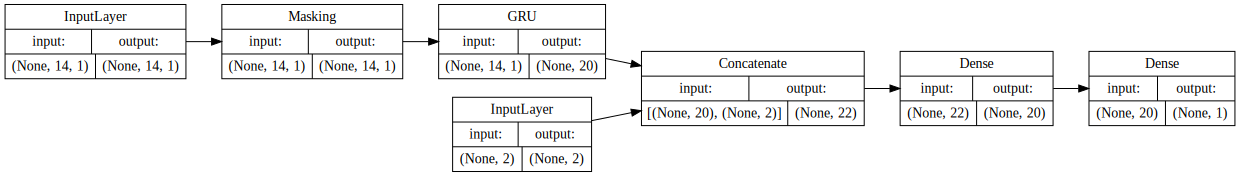

In [45]:
model = load_model('models/{}.h5'.format(file_rnn_20_20_sd0sort))
SVG(model_to_dot(model, True, False, 'LR').create(prog='dot', format='svg'))

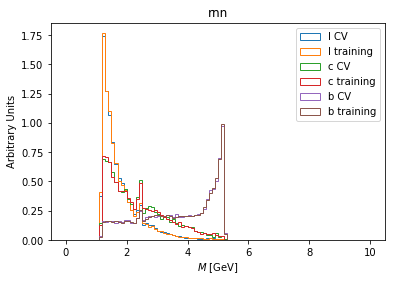

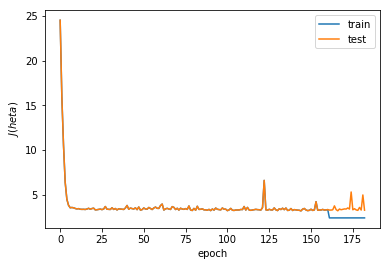

In [56]:
# Plots!
l_fpr_rnn_20_20_sd0sort, c_fpr_rnn_20_20_sd0sort, tpr_rnn_20_20_sd0sort = \
makeTrainingPlots(y_CV_pred_rnn_20_20_sd0sort, y_train_pred_rnn_20_20_sd0sort, history_rnn_20_20_sd0sort)

I was concerned that the validation error was noticably higher than the training error for this run. 
In my basic MLP, my training and validation errors were basically the same.

When the training error is smaller than the validation error, this suggests that I'm overfitting, so I need to apply some regularization technique, i.e, adding a dropout layer after the FC layer.
I'm going to start out by dropout 20% of the GLU output neurons for each mini-batch, and if this result looks promising, I can consider increasing the dropout fraction as well.

Train on 151666 samples, validate on 65000 samples
Epoch 1/50
151666/151666 [==============================] - 11s - loss: 2.7676 - val_loss: 7.2536
Epoch 2/50
151666/151666 [==============================] - 9s - loss: 2.6471 - val_loss: 4.4819
Epoch 3/50
151666/151666 [==============================] - 9s - loss: 2.5737 - val_loss: 3.6459
Epoch 4/50
151666/151666 [==============================] - 9s - loss: 2.5355 - val_loss: 3.5126
Epoch 5/50
151666/151666 [==============================] - 9s - loss: 2.5072 - val_loss: 3.4280
Epoch 6/50
151666/151666 [==============================] - 9s - loss: 2.4879 - val_loss: 3.3706
Epoch 7/50
151666/151666 [==============================] - 8s - loss: 2.4697 - val_loss: 3.3894
Epoch 8/50
151666/151666 [==============================] - 9s - loss: 2.4631 - val_loss: 3.3139
Epoch 9/50
151666/151666 [==============================] - 8s - loss: 2.4526 - val_loss: 3.3285
Epoch 10/50
151666/151666 [==============================] - 8s - loss: 2.4

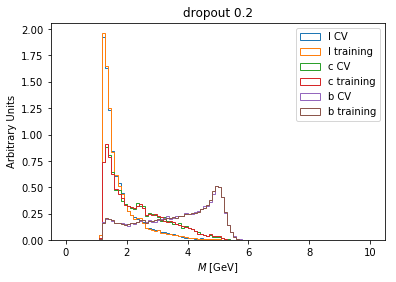

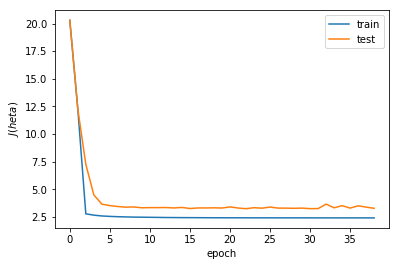

In [50]:
y_CV_pred_rnn_20dpt02_20, y_train_pred_rnn_20dpt02_20, history_rnn_20dpt02_20, file_rnn_20_20 = \
    RNN(nRNNUnits=20,nFCUnits=20,nEpochs=50,nTrkInputs=1,loadModel=True,dpt=0.2)
    
l_fpr_rnn_20dpt02_20, c_fpr_rnn_20dpt02_20, tpr_rnn_20dpt02_20 = \
    makeTrainingPlots(y_CV_pred_rnn_20dpt02_20, y_train_pred_rnn_20dpt02_20, 
                      history_rnn_20dpt02_20,tag='dropout 0.2')    

Also try a dropout of 0.5

ptPred_CV.shape = (65000,), ptPred_train.shape = (151666,)


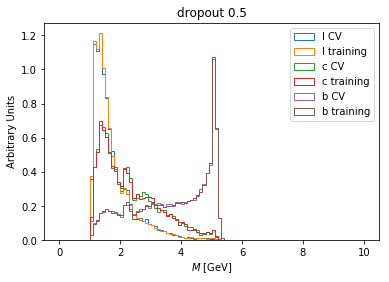

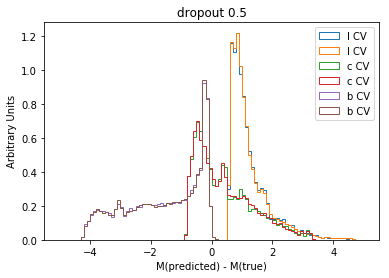

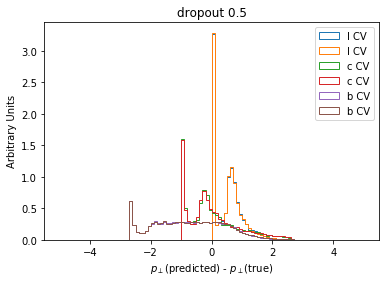

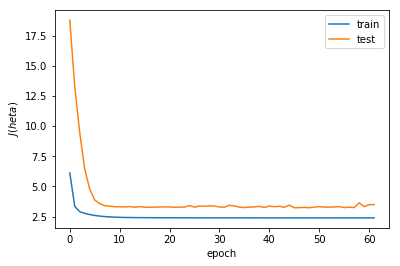

In [137]:
y_CV_pred_rnn_20dpt05_20, y_train_pred_rnn_20dpt05_20, history_rnn_20dpt05_20, file_rnn_20_20 = \
    RNN(nRNNUnits=20,nFCUnits=20,nEpochs=100,nTrkInputs=1,loadModel=True,dpt=0.5)
    
l_fpr_rnn_20dpt05_20, c_fpr_rnn_20dpt05_20, tpr_rnn_20dpt05_20 = \
    makeTrainingPlots(y_CV_pred_rnn_20dpt05_20, y_train_pred_rnn_20dpt05_20, 
                      history_rnn_20dpt05_20,tag='dropout 0.5') 

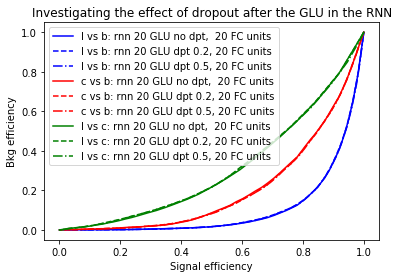

RNN loss w/o dropout: 3.18536467441
RNN loss dpt p = 0.2: 3.23022506708
RNN loss pt p = 0.5:  3.23501866722


In [58]:
plt.close('all')

plt.plot(tpr_rnn_20_20_sd0sort,l_fpr_rnn_20_20_sd0sort,'b-', label='l vs b: rnn 20 GLU no dpt,  20 FC units')
plt.plot(tpr_rnn_20dpt02_20,   l_fpr_rnn_20dpt02_20,   'b--',label='l vs b: rnn 20 GLU dpt 0.2, 20 FC units')
plt.plot(tpr_rnn_20dpt05_20,   l_fpr_rnn_20dpt05_20,   'b-.',label='l vs b: rnn 20 GLU dpt 0.5, 20 FC units')

plt.plot(tpr_rnn_20_20_sd0sort,c_fpr_rnn_20_20_sd0sort,'r-', label='c vs b: rnn 20 GLU no dpt,  20 FC units')
plt.plot(tpr_rnn_20dpt02_20,   c_fpr_rnn_20dpt02_20,   'r--',label='c vs b: rnn 20 GLU dpt 0.2, 20 FC units')
plt.plot(tpr_rnn_20dpt05_20,   c_fpr_rnn_20dpt05_20,   'r-.',label='c vs b: rnn 20 GLU dpt 0.5, 20 FC units')

plt.plot(c_fpr_rnn_20_20_sd0sort,l_fpr_rnn_20_20_sd0sort,'g-', label='l vs c: rnn 20 GLU no dpt,  20 FC units')
plt.plot(c_fpr_rnn_20dpt02_20,   l_fpr_rnn_20dpt02_20,   'g--',label='l vs c: rnn 20 GLU dpt 0.2, 20 FC units')
plt.plot(c_fpr_rnn_20dpt05_20,   l_fpr_rnn_20dpt05_20,   'g-.',label='l vs c: rnn 20 GLU dpt 0.5, 20 FC units')

plt.title('Investigating the effect of dropout after the GLU in the RNN')
plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()

print "RNN loss w/o dropout: {}".format(np.min(history_rnn_20_20_sd0sort.history['val_loss']))
print "RNN loss dpt p = 0.2: {}".format(np.min(history_rnn_20dpt02_20.history['val_loss']))
print "RNN loss pt p = 0.5:  {}".format(np.min(history_rnn_20dpt05_20.history['val_loss']))


In [ ]:
plt.close('all')

plt.plot(tpr_rnn_20_20_sd0sort,l_fpr_rnn_20_20_sd0sort,'b-', label='l vs b: rnn 20 GLU no dpt,  20 FC units')
plt.plot(tpr_rnn_20dpt02_20,   l_fpr_rnn_20dpt02_20,   'b--',label='l vs b: rnn 20 GLU dpt 0.2, 20 FC units')
plt.plot(tpr_rnn_20dpt05_20,   l_fpr_rnn_20dpt05_20,   'b-.',label='l vs b: rnn 20 GLU dpt 0.5, 20 FC units')

plt.plot(tpr_rnn_20_20_sd0sort,c_fpr_rnn_20_20_sd0sort,'r-', label='c vs b: rnn 20 GLU no dpt,  20 FC units')
plt.plot(tpr_rnn_20dpt02_20,   c_fpr_rnn_20dpt02_20,   'r--',label='c vs b: rnn 20 GLU dpt 0.2, 20 FC units')
plt.plot(tpr_rnn_20dpt05_20,   c_fpr_rnn_20dpt05_20,   'r-.',label='c vs b: rnn 20 GLU dpt 0.5, 20 FC units')

plt.plot(c_fpr_rnn_20_20_sd0sort,l_fpr_rnn_20_20_sd0sort,'g-', label='l vs c: rnn 20 GLU no dpt,  20 FC units')
plt.plot(c_fpr_rnn_20dpt02_20,   l_fpr_rnn_20dpt02_20,   'g--',label='l vs c: rnn 20 GLU dpt 0.2, 20 FC units')
plt.plot(c_fpr_rnn_20dpt05_20,   l_fpr_rnn_20dpt05_20,   'g-.',label='l vs c: rnn 20 GLU dpt 0.5, 20 FC units')

plt.title('Investigating the effect of dropout after the GLU in the RNN')
plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()

print "RNN loss w/o dropout: {}".format(np.min(history_rnn_20_20_sd0sort.history['val_loss']))
print "RNN loss dpt p = 0.2: {}".format(np.min(history_rnn_20dpt02_20.history['val_loss']))
print "RNN loss pt p = 0.5:  {}".format(np.min(history_rnn_20dpt05_20.history['val_loss']))

## Using LSTMs to solve the vanishing gradient problem

In [155]:
y_CV_pred_rnn_20LSTM_20_sd0sort, y_train_pred_rnn_20LSTM_20_sd0sort, history_rnn_20LSTM_20_sd0sort, file_rnn_20LSTM_20_sd0sort = \
    RNN(nRNNUnits=20,nFCUnits=20,nEpochs=100,batchSize=10000,nTrkInputs=1,recurrentLayer='LSTM',loadModel=True,dpt=0)

Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 10s - loss: 2.8309 - val_loss: 4.2331
Epoch 2/100
151666/151666 [==============================] - 5s - loss: 2.7806 - val_loss: 4.0541
Epoch 3/100
151666/151666 [==============================] - 6s - loss: 2.7398 - val_loss: 3.9467
Epoch 4/100
151666/151666 [==============================] - 5s - loss: 2.7070 - val_loss: 3.8893
Epoch 5/100
151666/151666 [==============================] - 5s - loss: 2.6804 - val_loss: 3.8470
Epoch 6/100
151666/151666 [==============================] - 5s - loss: 2.6592 - val_loss: 3.8304
Epoch 7/100
151666/151666 [==============================] - 5s - loss: 2.6413 - val_loss: 3.8094
Epoch 8/100
151666/151666 [==============================] - 5s - loss: 2.6266 - val_loss: 3.8709
Epoch 9/100
151666/151666 [==============================] - 5s - loss: 2.6135 - val_loss: 3.8194
Epoch 10/100
151666/151666 [==============================] - 6s -

151666/151666 [==============================] - 5s - loss: 2.4118 - val_loss: 3.3477
Epoch 69/100
151666/151666 [==============================] - 6s - loss: 2.4108 - val_loss: 3.3346
Epoch 70/100
151666/151666 [==============================] - 6s - loss: 2.4102 - val_loss: 3.3319
Epoch 71/100
151666/151666 [==============================] - 5s - loss: 2.4095 - val_loss: 3.3342
Epoch 72/100
151666/151666 [==============================] - 5s - loss: 2.4089 - val_loss: 3.3523
Epoch 73/100
151666/151666 [==============================] - 5s - loss: 2.4085 - val_loss: 3.3216
Epoch 74/100
151666/151666 [==============================] - 5s - loss: 2.4078 - val_loss: 3.3516
Epoch 75/100
151666/151666 [==============================] - 6s - loss: 2.4073 - val_loss: 3.3016
Epoch 76/100
151666/151666 [==============================] - 6s - loss: 2.4067 - val_loss: 3.3326
Epoch 77/100
151666/151666 [==============================] - 5s - loss: 2.4065 - val_loss: 3.3352
Epoch 78/100
151666/151

ptPred_CV.shape = (65000,), ptPred_train.shape = (151666,)


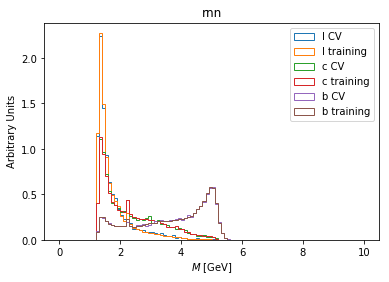

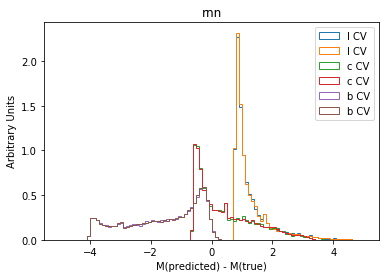

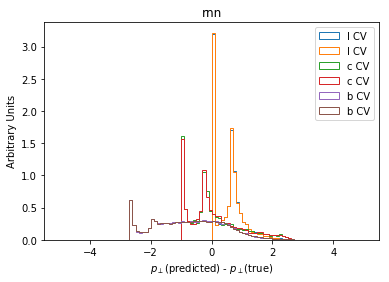

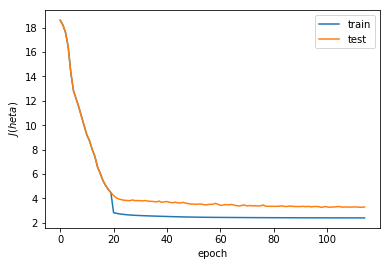

In [156]:
l_fpr_rnn_20LSTM_20_sd0sort, c_fpr_rnn_20LSTM_20_sd0sort, tpr_rnn_20LSTM_20_sd0sort = \
    makeTrainingPlots(y_CV_pred_rnn_20LSTM_20_sd0sort, y_train_pred_rnn_20LSTM_20_sd0sort, 
                      history_rnn_20LSTM_20_sd0sort)

Compare the curves for these two different solutions to solving the vanishing gradient problem for the RNN with the 10 hidden unit MLP roc curve.

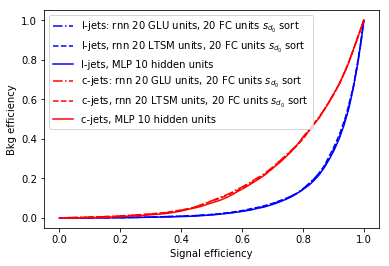

RNN loss w/ GLU:  3.18536467441
RNN loss w/ LSTM: 3.25998508013


In [157]:
plt.close('all')

plt.plot(tpr_rnn_20_20_sd0sort,    l_fpr_rnn_20_20_sd0sort,    'b-.',
         label='l-jets: rnn 20 GLU units, 20 FC units $s_{d_0}$ sort')
plt.plot(tpr_rnn_20LSTM_20_sd0sort,l_fpr_rnn_20LSTM_20_sd0sort,'b--', 
         label='l-jets, rnn 20 LTSM units, 20 FC units $s_{d_0}$ sort')
plt.plot(tpr_1lay_10units_mse,     l_fpr_1lay_10units_mse,'b-', 
         label='l-jets, MLP 10 hidden units')

plt.plot(tpr_rnn_20_20_sd0sort,    c_fpr_rnn_20_20_sd0sort,    'r-.',
         label='c-jets: rnn 20 GLU units, 20 FC units $s_{d_0}$ sort')
plt.plot(tpr_rnn_20LSTM_20_sd0sort,c_fpr_rnn_20LSTM_20_sd0sort,'r--', 
         label='c-jets, rnn 20 LTSM units, 20 FC units $s_{d_0}$ sort')
plt.plot(tpr_1lay_10units_mse,     c_fpr_1lay_10units_mse,'r-', 
         label='c-jets, MLP 10 hidden units')


plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()

print "RNN loss w/ GLU:  {}".format(np.min(history_rnn_20_20_sd0sort.history['val_loss']))
print "RNN loss w/ LSTM: {}".format(np.min(history_rnn_20LSTM_20_sd0sort.history['val_loss']))

# Inputting lower level information into the network

Try using an GLU and passing in all of the 4 vector information for the track and the jet, and seeing if the network can learn from that the parameters.

Then I could add the errors on the b-hadron flight direction $\theta$ and $\phi$ into the network and see if this changes the outcome at all, since this was one of the aspects that Su Dong wanted me to look at.

In [21]:
# Get the jet level variables
Z = jf_df[['jet_jf_theta','jet_jf_phi','jet_jf_theta_err','jet_jf_phi_err']][jf_df['jet_LabDr_HadF']!=15]

len(Z.index)
Z_train = Z.iloc[ix_train].values
Z_CV = Z.iloc[ix_CV].values

# Normalize the jet inputs
scaler = StandardScaler()
Z_train = scaler.fit_transform(Z_train)
Z_CV = scaler.transform(Z_CV)

# For now, just inputting hadron's flight direction 
jet_values = Z_train[:,:2]
jet_CV = Z_CV[:,:2]

# # The create stream function automatically normalizes the track inputs
df_trks = jf_df[['jet_trk_pt','jet_trk_eta','jet_trk_phi']]
Xtrk_train, Xtrk_CV = create_stream(df_trks, nTrks, sort_col='jet_trk_pt')


100%|██████████| 224057/224057 [00:58<00:00, 3853.62it/s]


Scaling feature 1 of 3 (jet_trk_pt).
Scaling feature 2 of 3 (jet_trk_eta).
Scaling feature 3 of 3 (jet_trk_phi).
Scaling feature 1 of 3 (jet_trk_pt).
Scaling feature 2 of 3 (jet_trk_eta).
Scaling feature 3 of 3 (jet_trk_phi).


In [28]:
y_CV_rnn_20_20_pTEtaPhi, y_train_rnn_20_20_pTEtaPhi, history_rnn_20_20_pTEtaPhi, filepath = \
    RNN(nRNNUnits=20,nFCUnits=20,nEpochs=10,nTrkInputs=-1,loadModel=False,dpt=0,useBatchNorm=True, tag='ptsort')

Train on 151666 samples, validate on 65000 samples
Epoch 1/10
151666/151666 [==============================] - 15s - loss: 4.4018 - val_loss: 6.0977
Epoch 2/10
151666/151666 [==============================] - 13s - loss: 3.9993 - val_loss: 5.9434
Epoch 3/10
151666/151666 [==============================] - 13s - loss: 3.9695 - val_loss: 5.7173
Epoch 4/10
151666/151666 [==============================] - 13s - loss: 3.9594 - val_loss: 5.6427
Epoch 5/10
151666/151666 [==============================] - 13s - loss: 3.9570 - val_loss: 5.6868
Epoch 6/10
151666/151666 [==============================] - 14s - loss: 3.9524 - val_loss: 5.7195
Epoch 7/10
151666/151666 [==============================] - 13s - loss: 3.9514 - val_loss: 5.8585
Epoch 8/10
151666/151666 [==============================] - 13s - loss: 3.9489 - val_loss: 6.1519
Epoch 9/10
151666/151666 [==============================] - 14s - loss: 3.9484 - val_loss: 5.6087
Epoch 10/10
151666/151666 [==============================] - 13s - 

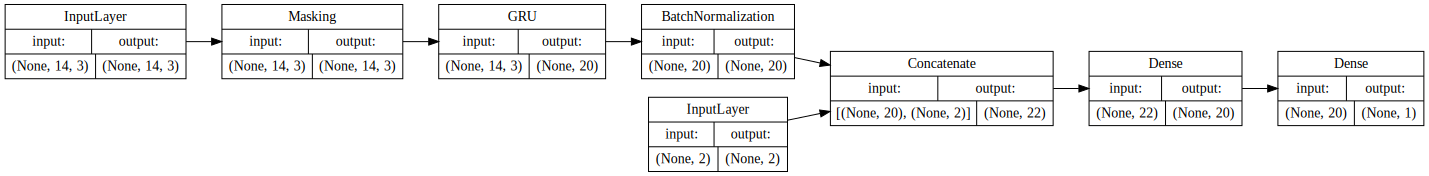

In [30]:
model = load_model('models/{}.h5'.format(filepath))
SVG(model_to_dot(model, True, False, 'LR').create(prog='dot', format='svg'))

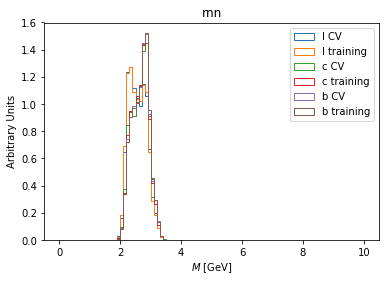

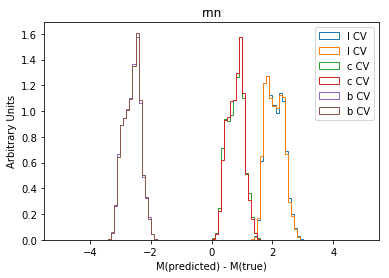

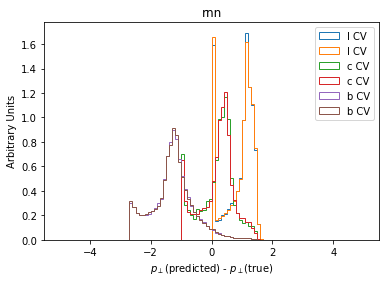

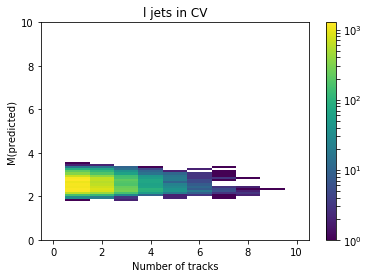

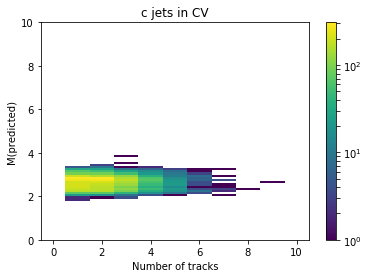

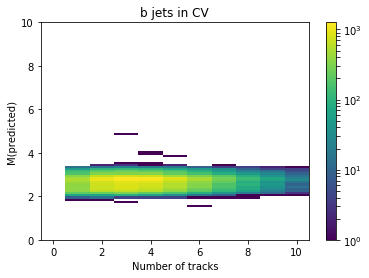

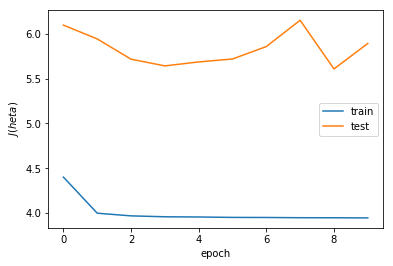

In [33]:
l_fpr_rnn_20_20_pTEtaPhi, c_fpr_rnn_20_20_pTEtaPhi, tpr_rnn_20_20_pTEtaPhi = \
makeTrainingPlots(y_CV_rnn_20_20_pTEtaPhi, y_train_rnn_20_20_pTEtaPhi, history_rnn_20_20_pTEtaPhi)

Since the range of output values for the mass are so narrow, I'm going to try increasing the complexity of the network to see if I can better learn the distribution of values.

For starters, I'm just going to dial this up from 20 to 50 to see if this tweak starts moving me in the right direction.

In [ ]:
y_CV_rnn_50_50_pTEtaPhi, y_train_rnn_50_50_pTEtaPhi, history_rnn_50_50_pTEtaPhi, filepath = \
    RNN(nRNNUnits=50,nFCUnits=50,nEpochs=100,nTrkInputs=-1,loadModel=True,dpt=0,useBatchNorm=True, tag='ptsort')

Loading the module previously saved in RNN_50_50_input_ptEtaPhi_ptsort
Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 27s - loss: 3.9403 - val_loss: 5.6032
Epoch 2/100
151666/151666 [==============================] - 26s - loss: 3.9383 - val_loss: 5.6444
Epoch 3/100
151666/151666 [==============================] - 26s - loss: 3.9396 - val_loss: 5.6891
Epoch 4/100
151666/151666 [==============================] - 26s - loss: 3.9390 - val_loss: 5.8003
Epoch 5/100
151666/151666 [==============================] - 26s - loss: 3.9385 - val_loss: 5.7290
Epoch 6/100
116992/151666 [======================>.......] - ETA: 5s - loss: 3.9400

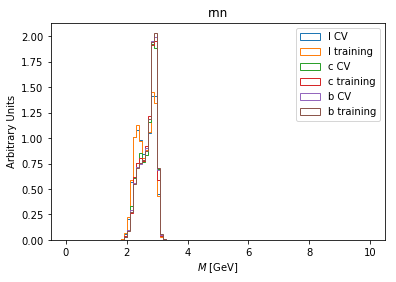

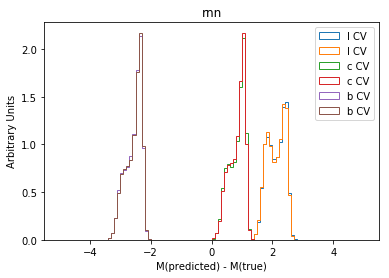

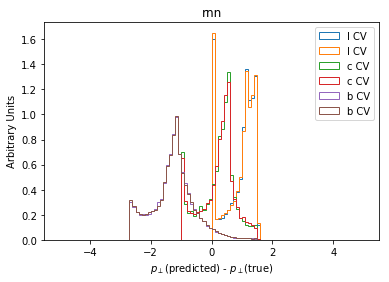

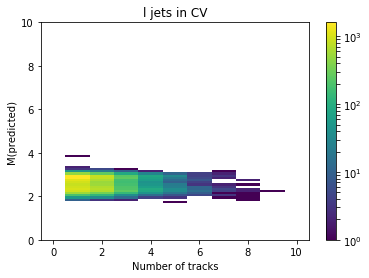

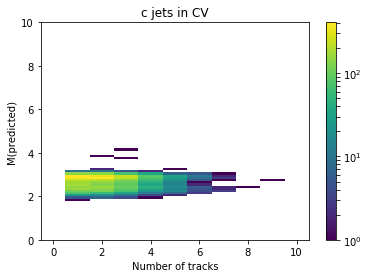

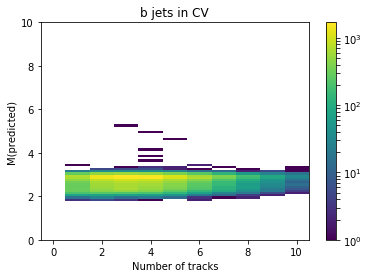

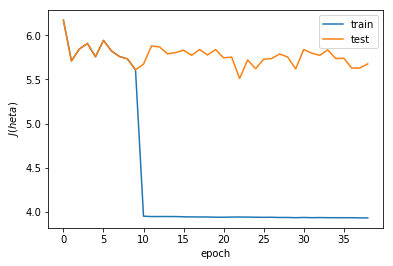

In [38]:
l_fpr_rnn_50_50_pTEtaPhi, c_fpr_rnn_50_50_pTEtaPhi, tpr_rnn_50_50_pTEtaPhi = \
makeTrainingPlots(y_CV_rnn_50_50_pTEtaPhi, y_train_rnn_50_50_pTEtaPhi, history_rnn_50_50_pTEtaPhi)

After training for 10 epochs, the (single) b/c spike appeared more pronounced, so I'm training over 100 epochs over lunch :)

In [37]:
y_CV_rnn_100_100_pTEtaPhi, y_train_rnn_100_100_pTEtaPhi, history_rnn_100_100_pTEtaPhi, filepath = \
    RNN(nRNNUnits=100,nFCUnits=100,nEpochs=100,nTrkInputs=-1,loadModel=False,dpt=0,useBatchNorm=True, tag='ptsort')

Train on 151666 samples, validate on 65000 samples
Epoch 1/100
151666/151666 [==============================] - 46s - loss: 4.2331 - val_loss: 6.2583
Epoch 2/100
151666/151666 [==============================] - 43s - loss: 4.0204 - val_loss: 5.7300
Epoch 3/100
151666/151666 [==============================] - 43s - loss: 3.9872 - val_loss: 5.7896
Epoch 4/100
151666/151666 [==============================] - 43s - loss: 3.9762 - val_loss: 5.8176
Epoch 5/100
151666/151666 [==============================] - 43s - loss: 3.9727 - val_loss: 5.7918
Epoch 6/100
151666/151666 [==============================] - 43s - loss: 3.9676 - val_loss: 5.6022
Epoch 7/100
151666/151666 [==============================] - 43s - loss: 3.9635 - val_loss: 5.8685
Epoch 8/100
151666/151666 [==============================] - 43s - loss: 3.9594 - val_loss: 5.8179
Epoch 9/100
151666/151666 [==============================] - 44s - loss: 3.9579 - val_loss: 5.7465
Epoch 10/100
151666/151666 [==============================

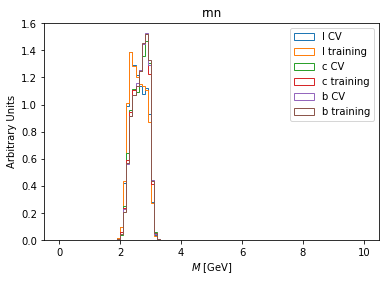

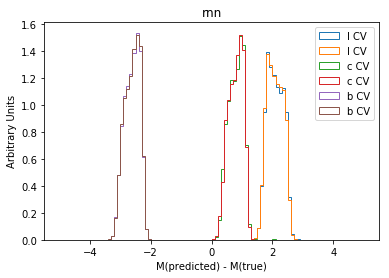

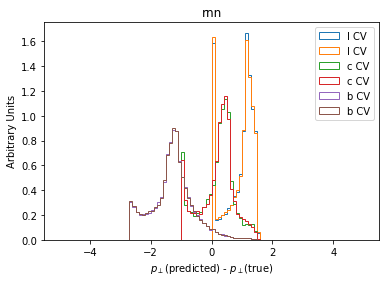

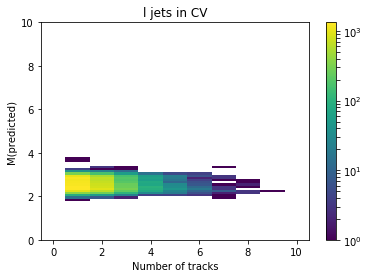

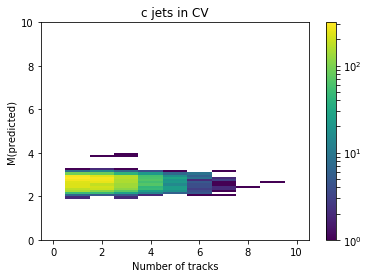

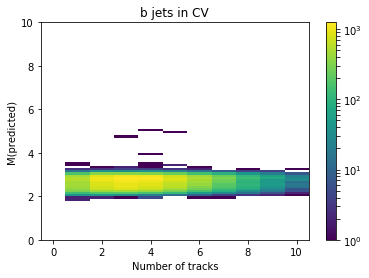

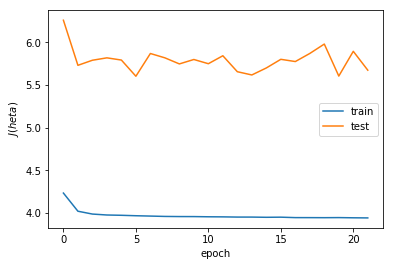

In [40]:
l_fpr_rnn_100_100_pTEtaPhi, c_fpr_rnn_100_100_pTEtaPhi, tpr_rnn_100_100_pTEtaPhi = \
makeTrainingPlots(y_CV_rnn_100_100_pTEtaPhi, y_train_rnn_100_100_pTEtaPhi, history_rnn_100_100_pTEtaPhi)

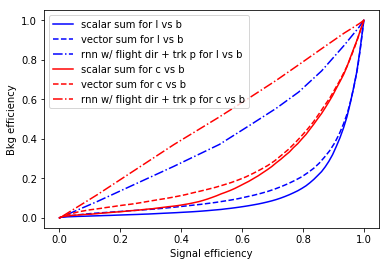

In [98]:
# Compare the discrimination against JF
plt.close('all')

plt.plot(tpr_SS,l_fpr_SS,'b',label='scalar sum for l vs b')
plt.plot(tpr_VS,l_fpr_VS,'b--',label='vector sum for l vs b')
plt.plot(tpr_rnn_20_20_pTEtaPhi,l_fpr_rnn_20_20_pTEtaPhi,'b-.',label='rnn w/ flight dir + trk p for l vs b')

plt.plot(tpr_SS,c_fpr_SS,'r',label='scalar sum for c vs b')
plt.plot(tpr_VS,c_fpr_VS,'r--',label='vector sum for c vs b')
plt.plot(tpr_rnn_20_20_pTEtaPhi,c_fpr_rnn_20_20_pTEtaPhi,'r-.',label='rnn w/ flight dir + trk p for c vs b')

# plt.plot(c_fpr_SS,l_fpr_SS,'g',label='scalar sum for l vs c')
# plt.plot(c_fpr_VS,l_fpr_VS,'g--',label='vector sum for l vs c')
# plt.plot(c_fpr_1lay_10units_mse,l_fpr_1lay_10units_mse,'g-.',label='10 unit MLP for l vs c')

plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='best')
plt.show()

## Try using batch normalization after the RELU to center the outputs

This allows the previous layers of the network to learn from similar distribtuions.


### Flight direction errors 
Next, add the errors from the flight direction into the network as well.

Implementation note: When I reset the global variables used by RNN(), I also need to reexecute RNN() so that it knows about the changes.

In [ ]:
jet_values = Z_train[:,:2]
jet_CV = Z_CV[:,:2]

In [ ]:
y_CV_rnn_20_20_pTEtaPhi_rErrs, y_train_rnn_20_20_pTEtaPhi_rErrs, history_rnn_20_20_pTEtaPhi_rErrs, filepath = \
    RNN(nRNNUnits=20,nFCUnits=20,nEpochs=50,nTrkInputs=-1,loadModel=True,dpt=0,tag='ptsort_rErrs')

In [ ]:
l_fpr_rnn_20_20_pTEtaPhi_rErrs, c_fpr_rnn_20_20_pTEtaPhi_rErrs, tpr_rnn_20_20_pTEtaPhi_rErrs = \
    makeTrainingPlots(y_CV_rnn_20_20_pTEtaPhi_rErrs, y_train_rnn_20_20_pTEtaPhi_rErrs, history_rnn_20_20_pTEtaPhi_rErrs)

Compare the performance of these RNNs with the previous ones that you've been looking at.

# Implement the attention mechanism

- Maybe it would be quickest just to add a boolean flag "attention" to the rnn() funcion?



# References:

### Neural Networks 
- Michael Nielson's book on neural networks
- Geoffrey Hintons' Neural Networks coursera course

### LSTMs
- LSTM tutorial http://deeplearning.net/tutorial/lstm.html
    
### Gated Linear Units
- Paper introducing GLUs (I haven't read this yet, but I've seen it referenced in multiple sources)
https://arxiv.org/pdf/1412.3555v1.pdf
  
### Attention Mechanism
- Michael's SLAC ATLAS talk   https://indico.cern.ch/event/660524/contributions/2694668/attachments/1509973/2354309/Kagan_btagML.pdf
- Hammers and Nails talk
https://erez.weizmann.ac.il/pls/htmldb/f?p=101:58:::NO:RP:P58_CODE,P58_FILE:5447,Y
- Attention Mechanism Blog Post
https://blog.heuritech.com/2016/01/20/attention-mechanism/


### Implementation
- Michela's Deep Learning Tutorial ipython nb:
http://localhost:7825/notebooks/FFNN_RNN.ipynb#
- Rafael's ipython notebook:
https://cernbox.cern.ch/index.php/s/HMCaNoPIrwG4qax
- Keras documentation
https://keras.io/layers/recurrent/
- Michael, Zihao, and Qi's RNNIP pub note
https://cds.cern.ch/record/2255226/files/ATL-PHYS-PUB-2017-003.pdf
- Attention Mechanism
https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py#L40-L47
